# Import Packages

In [1]:
import tensorflow as tf
# check the version
tf.__version__

'2.8.0'

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Conv2D, MaxPooling2D 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import imageio as iio
import random
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


# Read Datasets

In [5]:
filenames = ['angry','fearful','happy','neutral','sad','surprised']

In [6]:
def read_dataset(filename):
  path_1 = 'gdrive/Shareddrives/Deep Learning Group Work/archive/train/'+filename
  dir_list_1 = os.listdir(path_1)
  df_1 = np.zeros((len(dir_list_1),42,42))
  index = 0
  flag = 0
  for i in dir_list_1:
      if i != '.DS_Store':
          Im_path = path_1 + '/' + i
          img = iio.imread(Im_path)
          img_pil = Image.fromarray(img)
          img_42_42 = np.array(img_pil.resize((42, 42), Image.ANTIALIAS))
          df_1[index] = img_42_42.astype(int)
          index += 1
          if index == len(dir_list_1):
              flag = 1
              break
      if flag == 1:
          break           
      path = 'gdrive/Shareddrives/Deep Learning Group Work/archive/train/'+filename
  df_1 = df_1.astype(int) 
  return df_1

In [7]:
dfs = []
for filename in filenames:
  df_temp = read_dataset(filename)
  dfs.append(df_temp)

Text(0.5, 1.0, 'Angry')

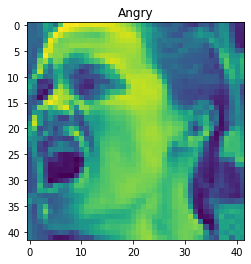

In [131]:
plt.imshow(dfs[0][80])
plt.title('Angry')

Text(0.5, 1.0, 'fearful')

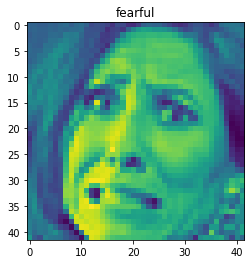

In [135]:
plt.imshow(dfs[1][50])
plt.title('fearful')

Text(0.5, 1.0, 'happy')

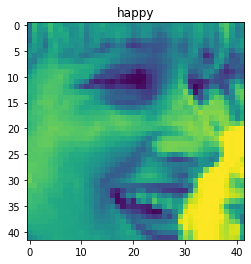

In [137]:
plt.imshow(dfs[2][90])
plt.title('happy')

Text(0.5, 1.0, 'neutral')

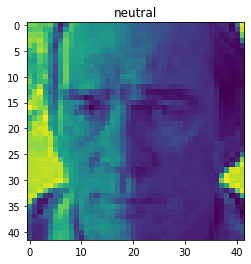

In [138]:
plt.imshow(dfs[3][98])
plt.title('neutral')

Text(0.5, 1.0, 'sad')

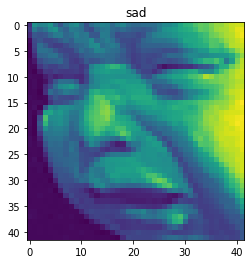

In [12]:
plt.imshow(dfs[4][99])
plt.title('sad')

Text(0.5, 1.0, 'surprised')

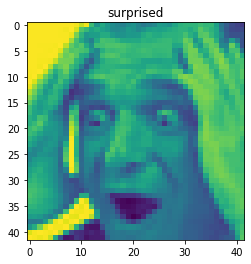

In [13]:
plt.imshow(dfs[5][99])
plt.title('surprised')

In [14]:
dfs[1].shape[0]
number_of_image = []
for df in dfs:
  number_of_image.append(df.shape[0])
number_of_image

[1006, 1000, 1000, 1000, 1000, 1000]

# Splitting Dataset

Training 60%, testing 20%, validation 20%

1000 images each category, 6 categories

In [15]:
1000*0.2*6

1200.0

In [16]:
def split_dataset(df):
  a = random.sample(range(0,1000),600)
  b = np.ones(400,)
  index = 0
  for value in range(0,1000):
    if value not in set(a):
      b[index] = int(value)
      index += 1
  c = list(b.astype(int))
  re = [ df[a,:], df[c[0:200],:],df[c[200:],:] ]
  return re 


In [17]:
dfs_split = []
for df in dfs:
  df_split = split_dataset(df)
  dfs_split.append(df_split)

In [18]:
#dfs_split is a list of lists
training_x = dfs_split[0][0]
cv_x = dfs_split[0][1]
test_x = dfs_split[0][2]
training_y = np.zeros((1,600))
cv_y = np.zeros((1,200))
test_y = np.zeros((1,200))
index = 1
for df in dfs_split[1:]:
  training_x = np.concatenate((training_x,df[0]),axis=0)
  cv_x = np.concatenate((cv_x,df[1]),axis=0)
  test_x = np.concatenate((test_x,df[2]),axis=0)
  training_y = np.concatenate((training_y,np.full((1,600),index)),axis=1)
  cv_y = np.concatenate((cv_y,np.full((1,200),index)),axis=1)
  test_y = np.concatenate((test_y,np.full((1,200),index)),axis=1)
  index += 1


Normalize data

In [19]:
training_x = training_x/255
cv_x = cv_x/255
test_x = test_x/255

In [20]:
print(np.unique(training_y))
print(np.unique(cv_y))
print(np.unique(test_y))

[0. 1. 2. 3. 4. 5.]
[0. 1. 2. 3. 4. 5.]
[0. 1. 2. 3. 4. 5.]


# 2) Fit training set well:

**Sequential Model**

In [21]:
print(training_x.shape)
print(test_x.shape)
print(cv_x.shape)

(3600, 42, 42)
(1200, 42, 42)
(1200, 42, 42)


In [22]:
# probably add .T at the end of this code for logistic regression and neural network
training_x_flatten = training_x.reshape(training_x.shape[0],-1)
test_x_flatten = test_x.reshape(test_x.shape[0],-1)
cv_x_flatten = cv_x.reshape(cv_x.shape[0],-1)

In [23]:
training_y = training_y.reshape(3600,)
test_y = test_y.reshape(1200,)
cv_y = cv_y.reshape(1200,)

In [24]:
print("train X shape: ", training_x_flatten.shape) # X_train: numpy array with shape: (num_samples_train, num_features)
print("train y shape: ", training_y.shape) # y_train: numpy array with shape: (num_samples_train,) 
print("test X shape: ", test_x_flatten.shape)   # X_test: numpy array with shape: (num_samples_test, num_features)
print("test y shape: ", test_y.shape)   # y_test: numpy array with shape: (num_samples_test,)
print("cv X shape: ", cv_x_flatten.shape)   # X_test: numpy array with shape: (num_samples_test, num_features)
print("cv y shape: ", cv_y.shape)   # y_test: numpy array with shape: (num_samples_test,)

train X shape:  (3600, 1764)
train y shape:  (3600,)
test X shape:  (1200, 1764)
test y shape:  (1200,)
cv X shape:  (1200, 1764)
cv y shape:  (1200,)


In [25]:
temp_train_x_flatten = np.concatenate((training_x_flatten,cv_x_flatten),axis=0)
temp_train_y = np.concatenate((training_y,cv_y),axis=0)

**Initial Sequential Model**

With one hidden layer, with 64 units, with a relu activation function. The output layer is a multi-class layer with 6 classes (activation function is softmax).

In [ ]:
model = Sequential([
    #Flatten(input_shape=(28,28)),
    Dense(64,activation='relu',input_shape=(1764,)),
    Dense(6,activation='softmax')
]
)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 64)                112960    
                                                                 
 dense_11 (Dense)            (None, 6)                 390       
                                                                 
Total params: 113,350
Trainable params: 113,350
Non-trainable params: 0
_________________________________________________________________


Compile the model. Used Adam optimizer and the learning rate=0.003. For loss, used 'sparse_categorical_crossentropy' and for metrics used 'SparseCategoricalAccuracy'.

In [ ]:
# compile the model

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.003),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [ ]:
model.weights

[<tf.Variable 'conv2d_8/kernel:0' shape=(3, 3, 1, 16) dtype=float32, numpy=
 array([[[[-2.99097262e-02, -1.42947301e-01, -1.64417997e-01,
            2.10494787e-01,  8.89360905e-03, -1.70531914e-01,
           -3.77183855e-02,  1.68046236e-01, -8.97159651e-02,
           -4.90564965e-02, -1.66271076e-01, -3.18153471e-01,
           -2.25023791e-01, -3.04487139e-01, -7.47383833e-02,
           -1.04781069e-01]],
 
         [[ 1.86288297e-01,  1.16411060e-01,  6.47277758e-02,
            2.46671647e-01, -1.92602620e-01,  1.48300916e-01,
            3.03346533e-02,  2.50584871e-01,  8.83064643e-02,
            1.30144516e-02, -2.09278509e-01, -2.85341963e-02,
           -1.01016402e-01,  9.68583152e-02,  3.74957502e-01,
           -1.75932888e-02]],
 
         [[ 1.67299375e-01,  3.40690725e-02, -2.03896180e-01,
           -2.19467524e-02, -3.37214321e-01, -7.11841136e-02,
           -1.38857633e-01,  2.87447244e-01,  1.63498864e-01,
            3.96012105e-02, -2.34206617e-01,  2.418042

Initial epochs = 300, batch_size = 64, verbose=2,validation_split=0.25

In [ ]:

history = model.fit(temp_train_x_flatten,temp_train_y,epochs=300,batch_size=64,verbose=2,validation_split=0.25)


Epoch 1/300
57/57 - 1s - loss: 2.1048 - sparse_categorical_accuracy: 0.1833 - val_loss: 1.7874 - val_sparse_categorical_accuracy: 0.1825 - 969ms/epoch - 17ms/step
Epoch 2/300
57/57 - 0s - loss: 1.7907 - sparse_categorical_accuracy: 0.1858 - val_loss: 1.7919 - val_sparse_categorical_accuracy: 0.1667 - 326ms/epoch - 6ms/step
Epoch 3/300
57/57 - 0s - loss: 1.7920 - sparse_categorical_accuracy: 0.1664 - val_loss: 1.7918 - val_sparse_categorical_accuracy: 0.1675 - 352ms/epoch - 6ms/step
Epoch 4/300
57/57 - 0s - loss: 1.7920 - sparse_categorical_accuracy: 0.1592 - val_loss: 1.7914 - val_sparse_categorical_accuracy: 0.1708 - 331ms/epoch - 6ms/step
Epoch 5/300
57/57 - 0s - loss: 1.7919 - sparse_categorical_accuracy: 0.1661 - val_loss: 1.7918 - val_sparse_categorical_accuracy: 0.1675 - 314ms/epoch - 6ms/step
Epoch 6/300
57/57 - 0s - loss: 1.7918 - sparse_categorical_accuracy: 0.1647 - val_loss: 1.7910 - val_sparse_categorical_accuracy: 0.1750 - 354ms/epoch - 6ms/step
Epoch 7/300
57/57 - 0s - lo

In [ ]:
df = pd.DataFrame(history.history)

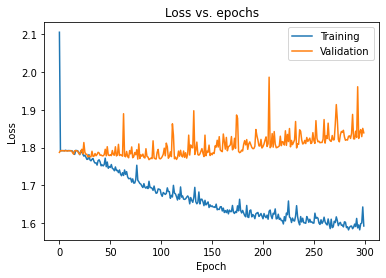

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

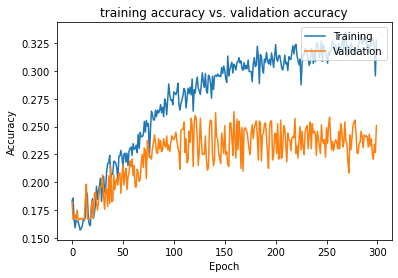

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
model.evaluate(test_x_flatten,test_y)

38/38 [==============================] - 0s 3ms/step - loss: 1.7753 - sparse_categorical_accuracy: 0.2750


[1.7752792835235596, 0.2750000059604645]

**2)-d**

A sequential model with more hidden layers

In [ ]:
model = Sequential([
    #Flatten(input_shape=(28,28)),
    Dense(64,activation='relu',input_shape=(1764,)),
    Dense(32,activation='relu',input_shape=(1764,)),
    Dense(32,activation='relu',input_shape=(1764,)),
    Dense(6,activation='softmax')
]
)

In [ ]:
# weight initialize 1
model = Sequential([
    #Flatten(input_shape=(28,28)),
    Dense(64,activation='relu',input_shape=(1764,),kernel_initializer='random_uniform', bias_initializer='zeros'),
    Dense(32,activation='relu',input_shape=(1764,),kernel_initializer='random_uniform', bias_initializer='zeros'),
    Dense(32,activation='relu',input_shape=(1764,),kernel_initializer='random_uniform', bias_initializer='zeros'),
    Dense(6,activation='softmax')
]
)

In [ ]:
# weight initialize 2
model = Sequential([
    #Flatten(input_shape=(28,28)),
    Dense(64,activation='relu',input_shape=(1764,),kernel_initializer='he_uniform', bias_initializer='ones'),
    Dense(32,activation='relu',input_shape=(1764,),kernel_initializer='he_uniform', bias_initializer='ones'),
    Dense(32,activation='relu',input_shape=(1764,),kernel_initializer='he_uniform', bias_initializer='ones'),
    Dense(6,activation='softmax')
]
)

In [ ]:
# weight initialize 3
model = Sequential([
    #Flatten(input_shape=(28,28)),
    Dense(64,activation='relu',input_shape=(1764,),kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4)),
    Dense(32,activation='relu',input_shape=(1764,),kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4)),
    Dense(32,activation='relu',input_shape=(1764,),kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4)),
    Dense(6,activation='softmax')
]
)

In [ ]:
# Optimizer is Adam
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.003),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [ ]:
# model fit result with optimizer = Adam
history = model.fit(temp_train_x_flatten,temp_train_y,epochs=300,batch_size=64,verbose=2,validation_split=0.25)
df = pd.DataFrame(history.history)

Epoch 1/300
57/57 - 5s - loss: 1.8422 - sparse_categorical_accuracy: 0.1703 - val_loss: 1.8000 - val_sparse_categorical_accuracy: 0.1675 - 5s/epoch - 95ms/step
Epoch 2/300
57/57 - 1s - loss: 1.7831 - sparse_categorical_accuracy: 0.1975 - val_loss: 1.8072 - val_sparse_categorical_accuracy: 0.1758 - 710ms/epoch - 12ms/step
Epoch 3/300
57/57 - 1s - loss: 1.7767 - sparse_categorical_accuracy: 0.2181 - val_loss: 1.7641 - val_sparse_categorical_accuracy: 0.2200 - 628ms/epoch - 11ms/step
Epoch 4/300
57/57 - 1s - loss: 1.7654 - sparse_categorical_accuracy: 0.2358 - val_loss: 1.7846 - val_sparse_categorical_accuracy: 0.2100 - 662ms/epoch - 12ms/step
Epoch 5/300
57/57 - 1s - loss: 1.7326 - sparse_categorical_accuracy: 0.2658 - val_loss: 1.7246 - val_sparse_categorical_accuracy: 0.2692 - 851ms/epoch - 15ms/step
Epoch 6/300
57/57 - 1s - loss: 1.7111 - sparse_categorical_accuracy: 0.2722 - val_loss: 1.7434 - val_sparse_categorical_accuracy: 0.2175 - 847ms/epoch - 15ms/step
Epoch 7/300
57/57 - 1s - 

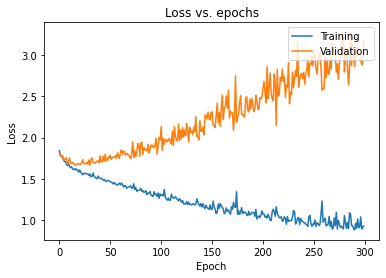

In [ ]:
# model graph result with optimizer = Adam
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

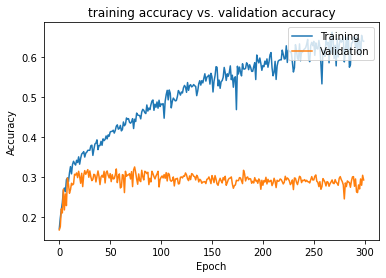

In [ ]:
# model graph result with optimizer = Adam
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# model test result with optimizer = Adam
model.evaluate(test_x_flatten,test_y)

38/38 [==============================] - 0s 2ms/step - loss: 3.1499 - sparse_categorical_accuracy: 0.2883


[3.1498775482177734, 0.28833332657814026]

In [ ]:
# Optimizer is SGD
model.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.003),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [ ]:
# model fit result with optimizer = SGD
history = model.fit(temp_train_x_flatten,temp_train_y,epochs=300,batch_size=64,verbose=2,validation_split=0.25)
df = pd.DataFrame(history.history)

Epoch 1/300
57/57 - 1s - loss: 1.7963 - sparse_categorical_accuracy: 0.1717 - val_loss: 1.7918 - val_sparse_categorical_accuracy: 0.1825 - 1s/epoch - 23ms/step
Epoch 2/300
57/57 - 0s - loss: 1.7904 - sparse_categorical_accuracy: 0.1744 - val_loss: 1.7893 - val_sparse_categorical_accuracy: 0.1750 - 262ms/epoch - 5ms/step
Epoch 3/300
57/57 - 0s - loss: 1.7873 - sparse_categorical_accuracy: 0.1833 - val_loss: 1.7886 - val_sparse_categorical_accuracy: 0.1792 - 240ms/epoch - 4ms/step
Epoch 4/300
57/57 - 0s - loss: 1.7849 - sparse_categorical_accuracy: 0.1853 - val_loss: 1.7874 - val_sparse_categorical_accuracy: 0.1758 - 279ms/epoch - 5ms/step
Epoch 5/300
57/57 - 0s - loss: 1.7825 - sparse_categorical_accuracy: 0.1878 - val_loss: 1.7867 - val_sparse_categorical_accuracy: 0.1817 - 252ms/epoch - 4ms/step
Epoch 6/300
57/57 - 0s - loss: 1.7810 - sparse_categorical_accuracy: 0.1892 - val_loss: 1.7856 - val_sparse_categorical_accuracy: 0.1875 - 292ms/epoch - 5ms/step
Epoch 7/300
57/57 - 0s - loss:

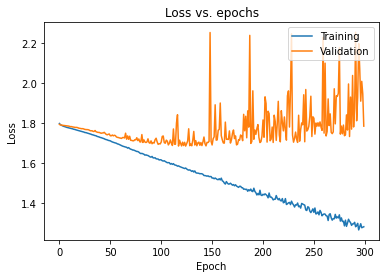

In [ ]:
# model graph result with optimizer = SGD
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

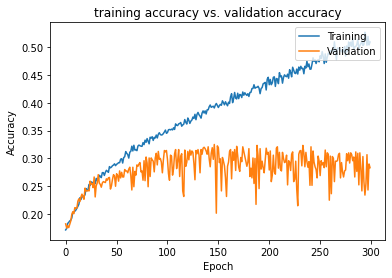

In [ ]:
# model graph result with optimizer = SGD
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# model test result with optimizer = SGD
model.evaluate(test_x_flatten,test_y)

38/38 [==============================] - 0s 4ms/step - loss: 1.7147 - sparse_categorical_accuracy: 0.3417


[1.7147365808486938, 0.34166666865348816]

In [ ]:
# Optimizer is Adamax
model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate=0.003),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

)

In [ ]:
# model fit result with optimizer = Adamax and epochs = 300
history = model.fit(temp_train_x_flatten,temp_train_y,epochs=300,batch_size=64,verbose=2,validation_split=0.25)
df = pd.DataFrame(history.history)

Epoch 1/300
57/57 - 1s - loss: 2.1769 - sparse_categorical_accuracy: 0.1942 - val_loss: 1.7901 - val_sparse_categorical_accuracy: 0.1858 - 1s/epoch - 26ms/step
Epoch 2/300
57/57 - 0s - loss: 1.7703 - sparse_categorical_accuracy: 0.2153 - val_loss: 1.7947 - val_sparse_categorical_accuracy: 0.1917 - 436ms/epoch - 8ms/step
Epoch 3/300
57/57 - 0s - loss: 1.7450 - sparse_categorical_accuracy: 0.2417 - val_loss: 1.7751 - val_sparse_categorical_accuracy: 0.2033 - 385ms/epoch - 7ms/step
Epoch 4/300
57/57 - 0s - loss: 1.7283 - sparse_categorical_accuracy: 0.2617 - val_loss: 1.7427 - val_sparse_categorical_accuracy: 0.2650 - 373ms/epoch - 7ms/step
Epoch 5/300
57/57 - 1s - loss: 1.7169 - sparse_categorical_accuracy: 0.2783 - val_loss: 1.7581 - val_sparse_categorical_accuracy: 0.2650 - 512ms/epoch - 9ms/step
Epoch 6/300
57/57 - 0s - loss: 1.7125 - sparse_categorical_accuracy: 0.2758 - val_loss: 1.7186 - val_sparse_categorical_accuracy: 0.2933 - 377ms/epoch - 7ms/step
Epoch 7/300
57/57 - 0s - loss:

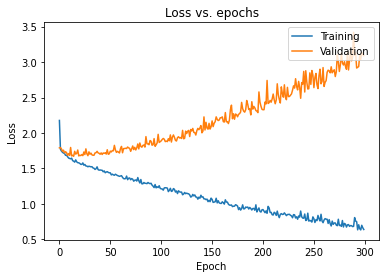

In [ ]:
# model graph result with optimizer = Adamax and epochs = 300
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

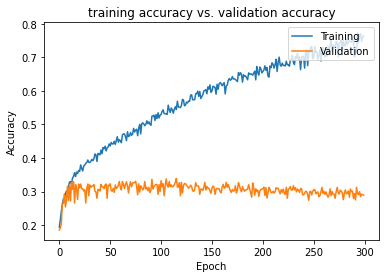

In [ ]:
# model graph result with optimizer = Adamax and epochs = 300
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# model test result with optimizer = Adamax and epochs = 300
model.evaluate(test_x_flatten,test_y)

38/38 [==============================] - 0s 3ms/step - loss: 2.9785 - sparse_categorical_accuracy: 0.3008


[2.9785006046295166, 0.3008333444595337]

In [ ]:
# model fit result with optimizer = Adamax and epochs = 100
history = model.fit(temp_train_x_flatten,temp_train_y,epochs=100,batch_size=64,verbose=2,validation_split=0.25)
df = pd.DataFrame(history.history)

Epoch 1/100
57/57 - 1s - loss: 1.8175 - sparse_categorical_accuracy: 0.1731 - val_loss: 1.7868 - val_sparse_categorical_accuracy: 0.1950 - 836ms/epoch - 15ms/step
Epoch 2/100
57/57 - 0s - loss: 1.7877 - sparse_categorical_accuracy: 0.1869 - val_loss: 1.8026 - val_sparse_categorical_accuracy: 0.1750 - 278ms/epoch - 5ms/step
Epoch 3/100
57/57 - 0s - loss: 1.7810 - sparse_categorical_accuracy: 0.2031 - val_loss: 1.7745 - val_sparse_categorical_accuracy: 0.2225 - 258ms/epoch - 5ms/step
Epoch 4/100
57/57 - 0s - loss: 1.7531 - sparse_categorical_accuracy: 0.2411 - val_loss: 1.7548 - val_sparse_categorical_accuracy: 0.2258 - 236ms/epoch - 4ms/step
Epoch 5/100
57/57 - 0s - loss: 1.7364 - sparse_categorical_accuracy: 0.2544 - val_loss: 1.7597 - val_sparse_categorical_accuracy: 0.2258 - 264ms/epoch - 5ms/step
Epoch 6/100
57/57 - 0s - loss: 1.7100 - sparse_categorical_accuracy: 0.2628 - val_loss: 1.7184 - val_sparse_categorical_accuracy: 0.2733 - 273ms/epoch - 5ms/step
Epoch 7/100
57/57 - 0s - lo

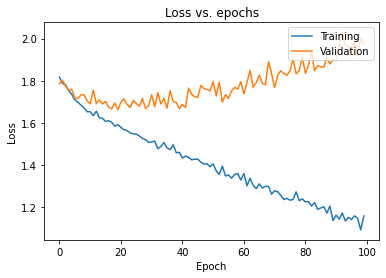

In [ ]:
# model graph result with optimizer = Adamax and epochs = 100
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

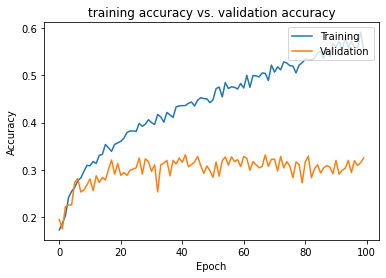

In [ ]:
# model graph result with optimizer = Adamax and epochs = 100
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# model test result with optimizer = Adamax and epochs = 100
model.evaluate(test_x_flatten,test_y)

38/38 [==============================] - 0s 4ms/step - loss: 1.8594 - sparse_categorical_accuracy: 0.3450


[1.8594492673873901, 0.3449999988079071]

In [ ]:
# model fit result with optimizer = Adamax and epochs = 500
history = model.fit(temp_train_x_flatten,temp_train_y,epochs=500,batch_size=64,verbose=2,validation_split=0.25)
df = pd.DataFrame(history.history)

Epoch 1/500
57/57 - 1s - loss: 1.1344 - sparse_categorical_accuracy: 0.5683 - val_loss: 1.9888 - val_sparse_categorical_accuracy: 0.2933 - 509ms/epoch - 9ms/step
Epoch 2/500
57/57 - 0s - loss: 1.1090 - sparse_categorical_accuracy: 0.5839 - val_loss: 1.9378 - val_sparse_categorical_accuracy: 0.3192 - 383ms/epoch - 7ms/step
Epoch 3/500
57/57 - 0s - loss: 1.0764 - sparse_categorical_accuracy: 0.5964 - val_loss: 1.9668 - val_sparse_categorical_accuracy: 0.3217 - 403ms/epoch - 7ms/step
Epoch 4/500
57/57 - 0s - loss: 1.0902 - sparse_categorical_accuracy: 0.5894 - val_loss: 1.9609 - val_sparse_categorical_accuracy: 0.3225 - 365ms/epoch - 6ms/step
Epoch 5/500
57/57 - 0s - loss: 1.0799 - sparse_categorical_accuracy: 0.5906 - val_loss: 1.9753 - val_sparse_categorical_accuracy: 0.3150 - 424ms/epoch - 7ms/step
Epoch 6/500
57/57 - 0s - loss: 1.1028 - sparse_categorical_accuracy: 0.5897 - val_loss: 1.9585 - val_sparse_categorical_accuracy: 0.3133 - 417ms/epoch - 7ms/step
Epoch 7/500
57/57 - 0s - los

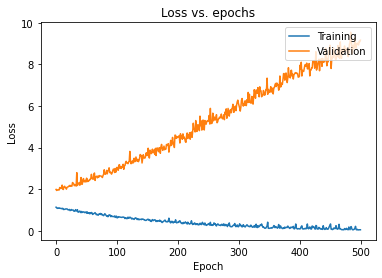

In [ ]:
# model graph result with optimizer = Adamax and epochs = 500
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

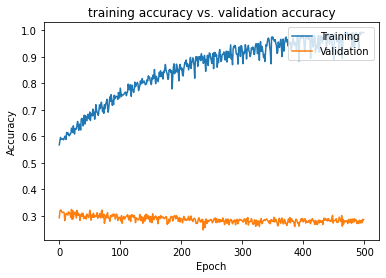

In [ ]:
# model graph result with optimizer = Adamax and epochs = 500
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# model test result with optimizer = Adamax and epochs = 500
model.evaluate(test_x_flatten,test_y)

38/38 [==============================] - 0s 3ms/step - loss: 8.5039 - sparse_categorical_accuracy: 0.3150


[8.503948211669922, 0.3149999976158142]

In [ ]:
# model fit result with optimizer = Adamax and epochs = 500 and using weight inilization 1
history = model.fit(temp_train_x_flatten,temp_train_y,epochs=500,batch_size=64,verbose=2,validation_split=0.25)
df = pd.DataFrame(history.history)

Epoch 1/500
57/57 - 1s - loss: 1.7921 - sparse_categorical_accuracy: 0.1642 - val_loss: 1.7880 - val_sparse_categorical_accuracy: 0.1683 - 899ms/epoch - 16ms/step
Epoch 2/500
57/57 - 0s - loss: 1.7854 - sparse_categorical_accuracy: 0.1944 - val_loss: 1.7773 - val_sparse_categorical_accuracy: 0.1950 - 289ms/epoch - 5ms/step
Epoch 3/500
57/57 - 0s - loss: 1.7711 - sparse_categorical_accuracy: 0.2089 - val_loss: 1.7650 - val_sparse_categorical_accuracy: 0.2392 - 294ms/epoch - 5ms/step
Epoch 4/500
57/57 - 0s - loss: 1.7430 - sparse_categorical_accuracy: 0.2339 - val_loss: 1.7514 - val_sparse_categorical_accuracy: 0.2150 - 289ms/epoch - 5ms/step
Epoch 5/500
57/57 - 0s - loss: 1.7211 - sparse_categorical_accuracy: 0.2481 - val_loss: 1.7308 - val_sparse_categorical_accuracy: 0.2625 - 286ms/epoch - 5ms/step
Epoch 6/500
57/57 - 0s - loss: 1.7014 - sparse_categorical_accuracy: 0.2617 - val_loss: 1.7197 - val_sparse_categorical_accuracy: 0.2633 - 266ms/epoch - 5ms/step
Epoch 7/500
57/57 - 0s - lo

In [ ]:
# model fit result with optimizer = Adamax and epochs = 500 and using weight inilization 2, 4 layers
# best model for Sequential
history = model.fit(temp_train_x_flatten,temp_train_y,epochs=500,batch_size=64,verbose=2,validation_split=0.25)
df = pd.DataFrame(history.history)

Epoch 1/500
57/57 - 1s - loss: 2.3490 - sparse_categorical_accuracy: 0.1719 - val_loss: 1.8439 - val_sparse_categorical_accuracy: 0.1692 - 856ms/epoch - 15ms/step
Epoch 2/500
57/57 - 0s - loss: 1.7940 - sparse_categorical_accuracy: 0.2025 - val_loss: 1.7894 - val_sparse_categorical_accuracy: 0.2183 - 263ms/epoch - 5ms/step
Epoch 3/500
57/57 - 0s - loss: 1.7582 - sparse_categorical_accuracy: 0.2292 - val_loss: 1.7609 - val_sparse_categorical_accuracy: 0.2392 - 272ms/epoch - 5ms/step
Epoch 4/500
57/57 - 0s - loss: 1.7317 - sparse_categorical_accuracy: 0.2506 - val_loss: 1.7539 - val_sparse_categorical_accuracy: 0.2175 - 288ms/epoch - 5ms/step
Epoch 5/500
57/57 - 0s - loss: 1.7318 - sparse_categorical_accuracy: 0.2414 - val_loss: 1.7377 - val_sparse_categorical_accuracy: 0.2417 - 262ms/epoch - 5ms/step
Epoch 6/500
57/57 - 0s - loss: 1.7062 - sparse_categorical_accuracy: 0.2761 - val_loss: 1.7455 - val_sparse_categorical_accuracy: 0.2658 - 280ms/epoch - 5ms/step
Epoch 7/500
57/57 - 0s - lo

In [ ]:
# model fit result with optimizer = Adamax and epochs = 500 and using weight inilization 3
history = model.fit(temp_train_x_flatten,temp_train_y,epochs=500,batch_size=64,verbose=2,validation_split=0.25)
df = pd.DataFrame(history.history)

Epoch 1/500
57/57 - 1s - loss: 1.8014 - sparse_categorical_accuracy: 0.1742 - val_loss: 1.7959 - val_sparse_categorical_accuracy: 0.1667 - 904ms/epoch - 16ms/step
Epoch 2/500
57/57 - 0s - loss: 1.7882 - sparse_categorical_accuracy: 0.1903 - val_loss: 1.7891 - val_sparse_categorical_accuracy: 0.1667 - 318ms/epoch - 6ms/step
Epoch 3/500
57/57 - 0s - loss: 1.7796 - sparse_categorical_accuracy: 0.1936 - val_loss: 1.7733 - val_sparse_categorical_accuracy: 0.2125 - 316ms/epoch - 6ms/step
Epoch 4/500
57/57 - 0s - loss: 1.7668 - sparse_categorical_accuracy: 0.2189 - val_loss: 1.7677 - val_sparse_categorical_accuracy: 0.2275 - 296ms/epoch - 5ms/step
Epoch 5/500
57/57 - 0s - loss: 1.7441 - sparse_categorical_accuracy: 0.2547 - val_loss: 1.7439 - val_sparse_categorical_accuracy: 0.2425 - 318ms/epoch - 6ms/step
Epoch 6/500
57/57 - 0s - loss: 1.7266 - sparse_categorical_accuracy: 0.2594 - val_loss: 1.7288 - val_sparse_categorical_accuracy: 0.2542 - 311ms/epoch - 5ms/step
Epoch 7/500
57/57 - 0s - lo

**Initial CNN Model**

In [26]:
# Build the Sequential convolutional neural network model

# the input layer with input_shape (1764,).
# the first hidden layer (conv1), has 16 filters with a shape of 3x3, with a relu activation function.
# the second hidden layer (pool1), is a max pooling layer, with size 3x3
# the third hidden layer, flatten/unroll to a long vector
# the fourth hidden layer, is a fully connected layer, with 64 units, with a relu activation function.
# the output (final) layer is a multi-class with 10 classes (activation function is softmax).

model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu'),
                    Dense(6, activation='softmax')
])


In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 40, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 38, 38, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 23104)             0         
                                                                 
 dense (Dense)               (None, 64)                1478720   
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 1,479,270
Trainable params: 1,479,270
Non-trainable params: 0
______________________________________________

CNN model compiling

In [28]:
temp_train_x = np.concatenate((training_x,cv_x),axis=0)
temp_train_y = np.concatenate((training_y,cv_y),axis=0)

In [29]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)

In [30]:
# fit the model with validation set

history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 10, batch_size = 100, verbose = 2,validation_split=0.25) 
# The 0.2 means that 20 percent of the training data will be held back for validation.

Epoch 1/10
36/36 - 6s - loss: 2.2088 - sparse_categorical_accuracy: 0.1986 - val_loss: 1.7555 - val_sparse_categorical_accuracy: 0.2158 - 6s/epoch - 157ms/step
Epoch 2/10
36/36 - 5s - loss: 1.6924 - sparse_categorical_accuracy: 0.2936 - val_loss: 1.6858 - val_sparse_categorical_accuracy: 0.2842 - 5s/epoch - 127ms/step
Epoch 3/10
36/36 - 5s - loss: 1.5911 - sparse_categorical_accuracy: 0.3583 - val_loss: 1.6505 - val_sparse_categorical_accuracy: 0.3075 - 5s/epoch - 127ms/step
Epoch 4/10
36/36 - 5s - loss: 1.4947 - sparse_categorical_accuracy: 0.4069 - val_loss: 1.6373 - val_sparse_categorical_accuracy: 0.3267 - 5s/epoch - 128ms/step
Epoch 5/10
36/36 - 5s - loss: 1.3836 - sparse_categorical_accuracy: 0.4644 - val_loss: 1.6800 - val_sparse_categorical_accuracy: 0.3325 - 5s/epoch - 128ms/step
Epoch 6/10
36/36 - 5s - loss: 1.2354 - sparse_categorical_accuracy: 0.5375 - val_loss: 1.7285 - val_sparse_categorical_accuracy: 0.3342 - 5s/epoch - 152ms/step
Epoch 7/10
36/36 - 5s - loss: 1.0985 - s

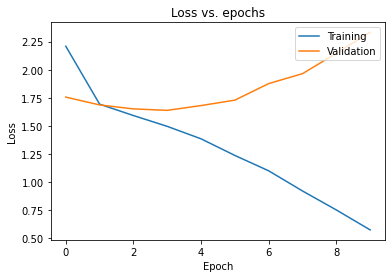

In [31]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

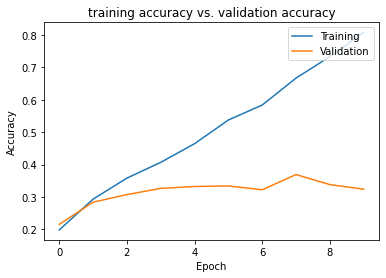

In [32]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [33]:
test_loss, test_accuracy = model.evaluate(test_x[..., np.newaxis], test_y.reshape((1200,)))
print('test_loss:',test_loss)
print('test_accuracy:',test_accuracy)

38/38 [==============================] - 1s 13ms/step - loss: 2.2833 - sparse_categorical_accuracy: 0.3575
test_loss: 2.283269166946411
test_accuracy: 0.35749998688697815


CNN with one more hidden layer

In [ ]:
model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu'),
                    Dense(32, activation = 'relu'),
                    Dense(6, activation='softmax')
])

In [ ]:
# weight inilization 1
model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer='random_uniform', bias_initializer='zeros'),
                    Dense(32, activation = 'relu',kernel_initializer='random_uniform', bias_initializer='zeros'),
                    Dense(6, activation='softmax',kernel_initializer='random_uniform', bias_initializer='zeros')
])

In [ ]:
# weight inilization 2
model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer='he_uniform', bias_initializer='ones'),
                    Dense(32, activation = 'relu',kernel_initializer='he_uniform', bias_initializer='ones'),
                    Dense(6, activation='softmax',kernel_initializer='he_uniform', bias_initializer='ones')
])

In [ ]:
# weight inilization 3
model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4))
])

In [ ]:
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 40, 40, 16)        160       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 38, 38, 16)       0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 23104)             0         
                                                                 
 dense_83 (Dense)            (None, 64)                1478720   
                                                                 
 dense_84 (Dense)            (None, 32)                2080      
                                                                 
 dense_85 (Dense)            (None, 6)                 198       
                                                     

In [ ]:
temp_train_x = np.concatenate((training_x,cv_x),axis=0)
temp_train_y = np.concatenate((training_y,cv_y),axis=0)

In [ ]:
# Optimizer = Adam
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)

In [ ]:
# Model fit result with Optimizer = Adam
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 10, batch_size = 100, verbose = 2,validation_split=0.25) 


Epoch 1/10
36/36 - 8s - loss: 2.2346 - sparse_categorical_accuracy: 0.1703 - val_loss: 1.7866 - val_sparse_categorical_accuracy: 0.1617 - 8s/epoch - 229ms/step
Epoch 2/10
36/36 - 5s - loss: 1.7484 - sparse_categorical_accuracy: 0.2425 - val_loss: 1.7427 - val_sparse_categorical_accuracy: 0.2550 - 5s/epoch - 149ms/step
Epoch 3/10
36/36 - 5s - loss: 1.6342 - sparse_categorical_accuracy: 0.3242 - val_loss: 1.6872 - val_sparse_categorical_accuracy: 0.2975 - 5s/epoch - 147ms/step
Epoch 4/10
36/36 - 5s - loss: 1.5104 - sparse_categorical_accuracy: 0.3900 - val_loss: 1.6777 - val_sparse_categorical_accuracy: 0.3108 - 5s/epoch - 147ms/step
Epoch 5/10
36/36 - 5s - loss: 1.4127 - sparse_categorical_accuracy: 0.4417 - val_loss: 1.6753 - val_sparse_categorical_accuracy: 0.3308 - 5s/epoch - 148ms/step
Epoch 6/10
36/36 - 5s - loss: 1.2609 - sparse_categorical_accuracy: 0.5075 - val_loss: 1.7511 - val_sparse_categorical_accuracy: 0.3458 - 5s/epoch - 150ms/step
Epoch 7/10
36/36 - 5s - loss: 1.0857 - s

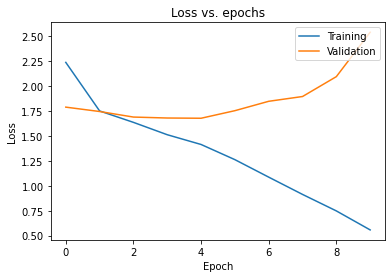

In [ ]:
# Model graph result with optimizer = Adam
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

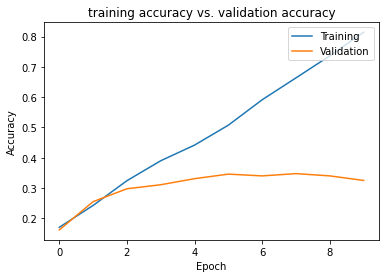

In [ ]:
# Model graph result with optimizer = Adam
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Model test result with Optimizer = Adam
test_loss, test_accuracy = model.evaluate(test_x[..., np.newaxis], test_y.reshape((1200,)))
print('test_loss:',test_loss)
print('test_accuracy:',test_accuracy)

38/38 [==============================] - 1s 25ms/step - loss: 2.5644 - sparse_categorical_accuracy: 0.3233
test_loss: 2.5644288063049316
test_accuracy: 0.3233333230018616


In [ ]:
# Optimizer = SGD
model.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)

In [ ]:
# Model fit result with Optimizer = SGD
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 10, batch_size = 100, verbose = 2,validation_split=0.25) 


Epoch 1/10
36/36 - 10s - loss: 1.7910 - sparse_categorical_accuracy: 0.1742 - val_loss: 1.7856 - val_sparse_categorical_accuracy: 0.1950 - 10s/epoch - 277ms/step
Epoch 2/10
36/36 - 6s - loss: 1.7853 - sparse_categorical_accuracy: 0.1961 - val_loss: 1.7820 - val_sparse_categorical_accuracy: 0.1892 - 6s/epoch - 166ms/step
Epoch 3/10
36/36 - 6s - loss: 1.7818 - sparse_categorical_accuracy: 0.2042 - val_loss: 1.7804 - val_sparse_categorical_accuracy: 0.2283 - 6s/epoch - 162ms/step
Epoch 4/10
36/36 - 6s - loss: 1.7782 - sparse_categorical_accuracy: 0.2053 - val_loss: 1.7817 - val_sparse_categorical_accuracy: 0.1875 - 6s/epoch - 164ms/step
Epoch 5/10
36/36 - 6s - loss: 1.7713 - sparse_categorical_accuracy: 0.2258 - val_loss: 1.7736 - val_sparse_categorical_accuracy: 0.1975 - 6s/epoch - 166ms/step
Epoch 6/10
36/36 - 6s - loss: 1.7662 - sparse_categorical_accuracy: 0.2278 - val_loss: 1.7755 - val_sparse_categorical_accuracy: 0.1967 - 6s/epoch - 165ms/step
Epoch 7/10
36/36 - 6s - loss: 1.7617 -

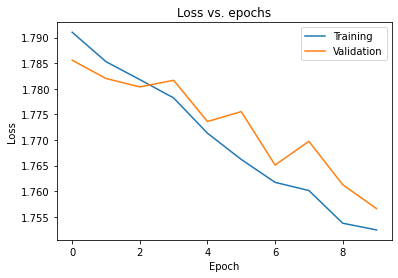

In [ ]:
# Model graph result with optimizer = SGD
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

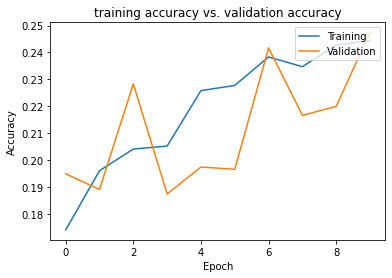

In [ ]:
# Model graph result with optimizer = SGD
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Model test result with Optimizer = SGD
test_loss, test_accuracy = model.evaluate(test_x[..., np.newaxis], test_y.reshape((1200,)))
print('test_loss:',test_loss)
print('test_accuracy:',test_accuracy)

38/38 [==============================] - 1s 29ms/step - loss: 1.7479 - sparse_categorical_accuracy: 0.2583
test_loss: 1.7479259967803955
test_accuracy: 0.25833332538604736


In [ ]:
# Optimizer = Adamax
model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)

In [ ]:
# Model fit result with Optimizer = Adamax and epochs = 10
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 10, batch_size = 100, verbose = 2,validation_split=0.25) 


Epoch 1/10
36/36 - 7s - loss: 2.4131 - sparse_categorical_accuracy: 0.1744 - val_loss: 1.7915 - val_sparse_categorical_accuracy: 0.1708 - 7s/epoch - 182ms/step
Epoch 2/10
36/36 - 6s - loss: 1.7737 - sparse_categorical_accuracy: 0.2092 - val_loss: 1.7586 - val_sparse_categorical_accuracy: 0.2317 - 6s/epoch - 159ms/step
Epoch 3/10
36/36 - 6s - loss: 1.7245 - sparse_categorical_accuracy: 0.2875 - val_loss: 1.7127 - val_sparse_categorical_accuracy: 0.2992 - 6s/epoch - 161ms/step
Epoch 4/10
36/36 - 6s - loss: 1.6683 - sparse_categorical_accuracy: 0.3250 - val_loss: 1.6812 - val_sparse_categorical_accuracy: 0.2950 - 6s/epoch - 164ms/step
Epoch 5/10
36/36 - 6s - loss: 1.6209 - sparse_categorical_accuracy: 0.3539 - val_loss: 1.6627 - val_sparse_categorical_accuracy: 0.2992 - 6s/epoch - 166ms/step
Epoch 6/10
36/36 - 6s - loss: 1.5923 - sparse_categorical_accuracy: 0.3669 - val_loss: 1.6468 - val_sparse_categorical_accuracy: 0.3092 - 6s/epoch - 166ms/step
Epoch 7/10
36/36 - 6s - loss: 1.5483 - s

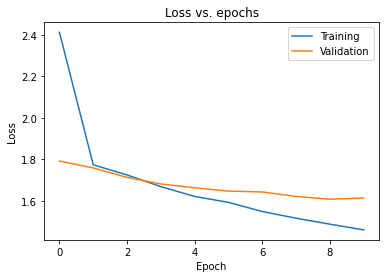

In [ ]:
# Model graph result with optimizer = Adamax and epochs = 10
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

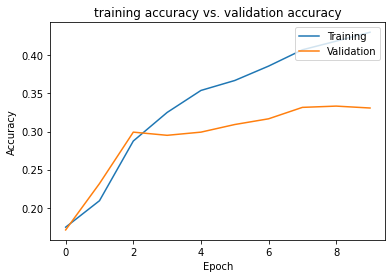

In [ ]:
# Model graph result with optimizer = Adamax and epochs = 10
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Model test result with Optimizer = Adamax and epochs = 10
test_loss, test_accuracy = model.evaluate(test_x[..., np.newaxis], test_y.reshape((1200,)))
print('test_loss:',test_loss)
print('test_accuracy:',test_accuracy)

38/38 [==============================] - 1s 16ms/step - loss: 1.5606 - sparse_categorical_accuracy: 0.3783
test_loss: 1.5606436729431152
test_accuracy: 0.37833333015441895


In [ ]:
# Model fit result with Optimizer = Adamax and epochs = 25
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 25, batch_size = 100, verbose = 2,validation_split=0.25) 


Epoch 1/25
36/36 - 6s - loss: 3.1530 - sparse_categorical_accuracy: 0.1631 - val_loss: 1.7939 - val_sparse_categorical_accuracy: 0.1950 - 6s/epoch - 176ms/step
Epoch 2/25
36/36 - 6s - loss: 1.7851 - sparse_categorical_accuracy: 0.1883 - val_loss: 1.7824 - val_sparse_categorical_accuracy: 0.1942 - 6s/epoch - 155ms/step
Epoch 3/25
36/36 - 6s - loss: 1.7656 - sparse_categorical_accuracy: 0.2319 - val_loss: 1.7658 - val_sparse_categorical_accuracy: 0.2075 - 6s/epoch - 155ms/step
Epoch 4/25
36/36 - 6s - loss: 1.7236 - sparse_categorical_accuracy: 0.2503 - val_loss: 1.7189 - val_sparse_categorical_accuracy: 0.2592 - 6s/epoch - 160ms/step
Epoch 5/25
36/36 - 6s - loss: 1.6682 - sparse_categorical_accuracy: 0.3069 - val_loss: 1.7062 - val_sparse_categorical_accuracy: 0.2850 - 6s/epoch - 164ms/step
Epoch 6/25
36/36 - 6s - loss: 1.6194 - sparse_categorical_accuracy: 0.3444 - val_loss: 1.6640 - val_sparse_categorical_accuracy: 0.3042 - 6s/epoch - 163ms/step
Epoch 7/25
36/36 - 6s - loss: 1.5813 - s

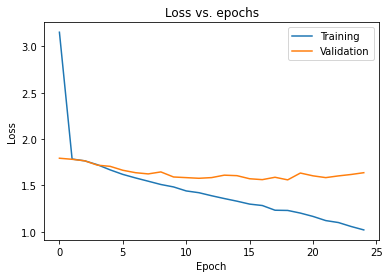

In [ ]:
# Model graph result with optimizer = Adamax and epochs = 25
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

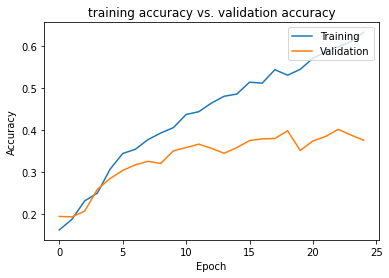

In [ ]:
# Model graph result with optimizer = Adamax and epochs = 25
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Model test result with Optimizer = Adamax and epochs = 25
test_loss, test_accuracy = model.evaluate(test_x[..., np.newaxis], test_y.reshape((1200,)))
print('test_loss:',test_loss)
print('test_accuracy:',test_accuracy)

38/38 [==============================] - 1s 25ms/step - loss: 1.6292 - sparse_categorical_accuracy: 0.4033
test_loss: 1.6291989088058472
test_accuracy: 0.4033333361148834


In [ ]:
# Model fit result with Optimizer = Adamax and epochs = 50
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 


Epoch 1/50
36/36 - 6s - loss: 1.9100 - sparse_categorical_accuracy: 0.1725 - val_loss: 1.7779 - val_sparse_categorical_accuracy: 0.2150 - 6s/epoch - 174ms/step
Epoch 2/50
36/36 - 6s - loss: 1.7379 - sparse_categorical_accuracy: 0.2519 - val_loss: 1.7249 - val_sparse_categorical_accuracy: 0.2608 - 6s/epoch - 155ms/step
Epoch 3/50
36/36 - 6s - loss: 1.6340 - sparse_categorical_accuracy: 0.3272 - val_loss: 1.6645 - val_sparse_categorical_accuracy: 0.3183 - 6s/epoch - 161ms/step
Epoch 4/50
36/36 - 6s - loss: 1.5255 - sparse_categorical_accuracy: 0.3989 - val_loss: 1.6356 - val_sparse_categorical_accuracy: 0.3325 - 6s/epoch - 166ms/step
Epoch 5/50
36/36 - 6s - loss: 1.4439 - sparse_categorical_accuracy: 0.4422 - val_loss: 1.5775 - val_sparse_categorical_accuracy: 0.3650 - 6s/epoch - 169ms/step
Epoch 6/50
36/36 - 6s - loss: 1.3732 - sparse_categorical_accuracy: 0.4736 - val_loss: 1.5993 - val_sparse_categorical_accuracy: 0.3517 - 6s/epoch - 169ms/step
Epoch 7/50
36/36 - 6s - loss: 1.3051 - s

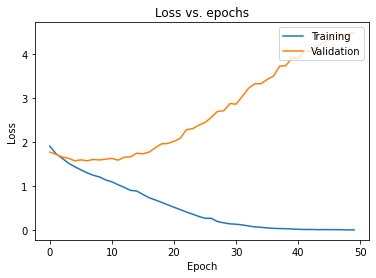

In [ ]:
# Model graph result with optimizer = Adamax and epochs = 50
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

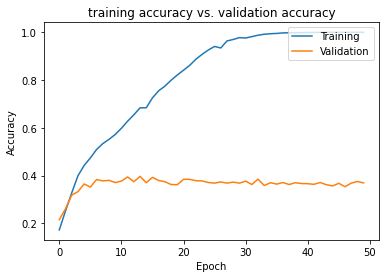

In [ ]:
# Model graph result with optimizer = Adamax and epochs = 50
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Model test result with Optimizer = Adamax and epochs = 50
test_loss, test_accuracy = model.evaluate(test_x[..., np.newaxis], test_y.reshape((1200,)))
print('test_loss:',test_loss)
print('test_accuracy:',test_accuracy)

38/38 [==============================] - 1s 16ms/step - loss: 4.3431 - sparse_categorical_accuracy: 0.3842
test_loss: 4.3430562019348145
test_accuracy: 0.3841666579246521


In [ ]:
# Model fit result with Optimizer = Adamax and epochs = 50, weight inilization 1
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 


Epoch 1/50
36/36 - 7s - loss: 1.7942 - sparse_categorical_accuracy: 0.1819 - val_loss: 1.7875 - val_sparse_categorical_accuracy: 0.2008 - 7s/epoch - 185ms/step
Epoch 2/50
36/36 - 6s - loss: 1.7769 - sparse_categorical_accuracy: 0.2217 - val_loss: 1.7552 - val_sparse_categorical_accuracy: 0.2467 - 6s/epoch - 174ms/step
Epoch 3/50
36/36 - 6s - loss: 1.7318 - sparse_categorical_accuracy: 0.2575 - val_loss: 1.7074 - val_sparse_categorical_accuracy: 0.2858 - 6s/epoch - 179ms/step
Epoch 4/50
36/36 - 6s - loss: 1.6565 - sparse_categorical_accuracy: 0.3042 - val_loss: 1.6468 - val_sparse_categorical_accuracy: 0.3208 - 6s/epoch - 179ms/step
Epoch 5/50
36/36 - 6s - loss: 1.5790 - sparse_categorical_accuracy: 0.3561 - val_loss: 1.6269 - val_sparse_categorical_accuracy: 0.3283 - 6s/epoch - 180ms/step
Epoch 6/50
36/36 - 6s - loss: 1.5338 - sparse_categorical_accuracy: 0.3800 - val_loss: 1.6120 - val_sparse_categorical_accuracy: 0.3217 - 6s/epoch - 180ms/step
Epoch 7/50
36/36 - 6s - loss: 1.4924 - s

In [ ]:
# Model fit result with Optimizer = Adamax and epochs = 50, weight inilization 2
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 


Epoch 1/50
36/36 - 6s - loss: 3.1624 - sparse_categorical_accuracy: 0.1831 - val_loss: 1.8377 - val_sparse_categorical_accuracy: 0.1792 - 6s/epoch - 174ms/step
Epoch 2/50
36/36 - 6s - loss: 1.7821 - sparse_categorical_accuracy: 0.2119 - val_loss: 1.7309 - val_sparse_categorical_accuracy: 0.2783 - 6s/epoch - 154ms/step
Epoch 3/50
36/36 - 6s - loss: 1.6709 - sparse_categorical_accuracy: 0.3083 - val_loss: 1.6983 - val_sparse_categorical_accuracy: 0.2750 - 6s/epoch - 156ms/step
Epoch 4/50
36/36 - 6s - loss: 1.5734 - sparse_categorical_accuracy: 0.3719 - val_loss: 1.6237 - val_sparse_categorical_accuracy: 0.3450 - 6s/epoch - 157ms/step
Epoch 5/50
36/36 - 6s - loss: 1.4876 - sparse_categorical_accuracy: 0.4164 - val_loss: 1.6237 - val_sparse_categorical_accuracy: 0.3442 - 6s/epoch - 159ms/step
Epoch 6/50
36/36 - 6s - loss: 1.3968 - sparse_categorical_accuracy: 0.4531 - val_loss: 1.5691 - val_sparse_categorical_accuracy: 0.3725 - 6s/epoch - 159ms/step
Epoch 7/50
36/36 - 6s - loss: 1.3137 - s

In [ ]:
# Model fit result with Optimizer = Adamax and epochs = 50, weight inilization 3
# Best model for CNN
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 


Epoch 1/50
36/36 - 6s - loss: 1.7914 - sparse_categorical_accuracy: 0.1842 - val_loss: 1.7810 - val_sparse_categorical_accuracy: 0.2500 - 6s/epoch - 178ms/step
Epoch 2/50
36/36 - 6s - loss: 1.7369 - sparse_categorical_accuracy: 0.2764 - val_loss: 1.7413 - val_sparse_categorical_accuracy: 0.2458 - 6s/epoch - 171ms/step
Epoch 3/50
36/36 - 6s - loss: 1.6185 - sparse_categorical_accuracy: 0.3303 - val_loss: 1.6491 - val_sparse_categorical_accuracy: 0.3192 - 6s/epoch - 175ms/step
Epoch 4/50
36/36 - 6s - loss: 1.5365 - sparse_categorical_accuracy: 0.3747 - val_loss: 1.5920 - val_sparse_categorical_accuracy: 0.3708 - 6s/epoch - 172ms/step
Epoch 5/50
36/36 - 6s - loss: 1.4424 - sparse_categorical_accuracy: 0.4281 - val_loss: 1.5689 - val_sparse_categorical_accuracy: 0.3700 - 6s/epoch - 176ms/step
Epoch 6/50
36/36 - 6s - loss: 1.3750 - sparse_categorical_accuracy: 0.4603 - val_loss: 1.5664 - val_sparse_categorical_accuracy: 0.3708 - 6s/epoch - 176ms/step
Epoch 7/50
36/36 - 6s - loss: 1.3002 - s

**Logistic Regression Model (No Hidden Layers)**

In [ ]:
temp_train_x = np.concatenate((training_x,cv_x),axis=0)
temp_train_y = np.concatenate((training_y,cv_y),axis=1)

In [ ]:
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
import tensorflow as tf

#(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
#x_train, x_test = x_train/255., x_test/255.
x_train = temp_train_x
y_train = temp_train_y.reshape((4800,)).astype(int)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25)
x_test = test_x
y_test = test_y.reshape((1200,)).astype(int)

x_train = tf.reshape(x_train, shape=(-1, 1764))
x_val  = tf.reshape(x_val, shape=(-1, 1764))
x_test = tf.reshape(x_test,shape=(-1,1764))

weights = tf.Variable(tf.random.normal(shape=(1764, 6), dtype=tf.float64))
biases  = tf.Variable(tf.random.normal(shape=(6,), dtype=tf.float64))

def logistic_regression(x):
    lr = tf.add(tf.matmul(x, weights), biases)
    #return tf.nn.sigmoid(lr)
    return lr


def cross_entropy(y_true, y_pred):
    y_true = tf.one_hot(y_true, 6)
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    return tf.reduce_mean(loss)

def accuracy(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    preds = tf.cast(tf.argmax(y_pred, axis=1), dtype=tf.float32)
    preds = tf.equal(y_true, preds)
    return tf.reduce_mean(tf.cast(preds, dtype=tf.float32))

def grad(x, y):
    with tf.GradientTape() as tape:
        y_pred = logistic_regression(x)
        loss_val = cross_entropy(y, y_pred)
    return tape.gradient(loss_val, [weights, biases])

n_batches = 100
learning_rate = 0.01
batch_size = 360

dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.repeat().shuffle(x_train.shape[0]).batch(batch_size)

dataset_val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
dataset_val = dataset_val.repeat().shuffle(x_val.shape[0]).batch(1200)
dataset_val

dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
dataset_test = dataset_test.repeat().shuffle(x_test.shape[0]).batch(1200)
dataset_test
epochs = 10
while epochs != 0:
  optimizer = tf.optimizers.SGD(learning_rate)
  for batch_numb, (batch_xs, batch_ys) in enumerate(dataset.take(n_batches), 1):
    gradients = grad(batch_xs, batch_ys)
    optimizer.apply_gradients(zip(gradients, [weights, biases]))

    y_pred = logistic_regression(batch_xs)
    loss = cross_entropy(batch_ys, y_pred)
    acc = accuracy(batch_ys, y_pred)
    
  print("epochs: %i, training loss: %f, training accuracy: %f" % (10-epochs+1, loss, acc))
  epochs -= 1

epochs: 1, training loss: 10.987419, training accuracy: 0.150000
epochs: 2, training loss: 10.488201, training accuracy: 0.150000
epochs: 3, training loss: 9.519723, training accuracy: 0.186111
epochs: 4, training loss: 8.593318, training accuracy: 0.172222
epochs: 5, training loss: 7.704513, training accuracy: 0.186111
epochs: 6, training loss: 7.956160, training accuracy: 0.147222
epochs: 7, training loss: 7.482730, training accuracy: 0.183333
epochs: 8, training loss: 7.043575, training accuracy: 0.194444
epochs: 9, training loss: 6.924741, training accuracy: 0.219444
epochs: 10, training loss: 6.711440, training accuracy: 0.202778


In [ ]:
for batch_numb, (batch_xs, batch_ys) in enumerate(dataset_val.take(1),1):
  y_pred = logistic_regression(batch_xs)
  loss = cross_entropy(batch_ys, y_pred)
  acc = accuracy(batch_ys, y_pred)
  print("Batch number: %i, val loss: %f, val accuracy: %f" % (batch_numb, loss, acc))

Batch number: 1, val loss: 6.915089, val accuracy: 0.168333


In [ ]:
for batch_numb, (batch_xs, batch_ys) in enumerate(dataset_test.take(1),1):
  y_pred = logistic_regression(batch_xs)
  loss = cross_entropy(batch_ys, y_pred)
  acc = accuracy(batch_ys, y_pred)
  print("Batch number: %i, test loss: %f, test accuracy: %f" % (batch_numb, loss, acc))

Batch number: 1, test loss: 7.292312, test accuracy: 0.162500


# Q3 Fit Validation Set


a. How well does your model fit the validation data compared to training performance? Explain if you have an overfitting problem.

-> It has overfitting problem.

In [105]:
temp_train_x = np.concatenate((training_x,cv_x),axis=0)
temp_train_y = np.concatenate((training_y,cv_y),axis=0)

In [54]:
# Best model for Q2 (CNN)
model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4))
])

In [56]:
model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)

In [57]:
# Model fit result with Optimizer = Adamax and epochs = 50, weight inilization 3
# Best model for CNN
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 

Epoch 1/50
36/36 - 6s - loss: 1.7964 - sparse_categorical_accuracy: 0.1694 - val_loss: 1.7897 - val_sparse_categorical_accuracy: 0.1667 - 6s/epoch - 161ms/step
Epoch 2/50
36/36 - 6s - loss: 1.7767 - sparse_categorical_accuracy: 0.2044 - val_loss: 1.7565 - val_sparse_categorical_accuracy: 0.2275 - 6s/epoch - 159ms/step
Epoch 3/50
36/36 - 6s - loss: 1.7330 - sparse_categorical_accuracy: 0.2475 - val_loss: 1.7220 - val_sparse_categorical_accuracy: 0.2558 - 6s/epoch - 161ms/step
Epoch 4/50
36/36 - 6s - loss: 1.6703 - sparse_categorical_accuracy: 0.2833 - val_loss: 1.6886 - val_sparse_categorical_accuracy: 0.2692 - 6s/epoch - 162ms/step
Epoch 5/50
36/36 - 6s - loss: 1.6261 - sparse_categorical_accuracy: 0.3175 - val_loss: 1.6503 - val_sparse_categorical_accuracy: 0.2925 - 6s/epoch - 161ms/step
Epoch 6/50
36/36 - 6s - loss: 1.5853 - sparse_categorical_accuracy: 0.3419 - val_loss: 1.6345 - val_sparse_categorical_accuracy: 0.3108 - 6s/epoch - 160ms/step
Epoch 7/50
36/36 - 6s - loss: 1.5504 - s

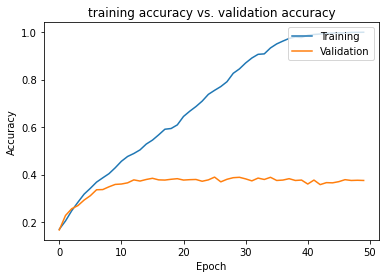

In [58]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [106]:
99.94-37.5

62.44

b. Can you improve your validation performance using L2 regularization? Report a table in which you show the validation performance for five different penalty (𝜆) rates.

In [59]:
# 1. lambda = 0.001
model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.001))
])

model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 

Epoch 1/50
36/36 - 9s - loss: 1.9906 - sparse_categorical_accuracy: 0.1667 - val_loss: 1.8144 - val_sparse_categorical_accuracy: 0.1667 - 9s/epoch - 251ms/step
Epoch 2/50
36/36 - 6s - loss: 1.7987 - sparse_categorical_accuracy: 0.2039 - val_loss: 1.7931 - val_sparse_categorical_accuracy: 0.1808 - 6s/epoch - 166ms/step
Epoch 3/50
36/36 - 6s - loss: 1.7829 - sparse_categorical_accuracy: 0.2189 - val_loss: 1.7695 - val_sparse_categorical_accuracy: 0.2250 - 6s/epoch - 167ms/step
Epoch 4/50
36/36 - 6s - loss: 1.7672 - sparse_categorical_accuracy: 0.2361 - val_loss: 1.7693 - val_sparse_categorical_accuracy: 0.2333 - 6s/epoch - 164ms/step
Epoch 5/50
36/36 - 6s - loss: 1.7277 - sparse_categorical_accuracy: 0.2597 - val_loss: 1.7312 - val_sparse_categorical_accuracy: 0.2750 - 6s/epoch - 164ms/step
Epoch 6/50
36/36 - 6s - loss: 1.7055 - sparse_categorical_accuracy: 0.2850 - val_loss: 1.7479 - val_sparse_categorical_accuracy: 0.2633 - 6s/epoch - 161ms/step
Epoch 7/50
36/36 - 6s - loss: 1.6691 - s

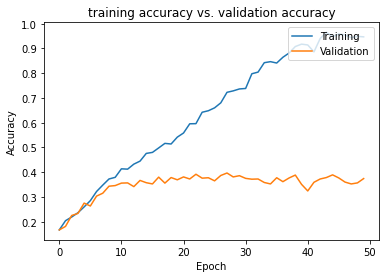

In [60]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [107]:
94.69-37.42

57.269999999999996

In [61]:
# 2. lambda = 0.005
model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.005)),
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.005)),
                    Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.005))
])

model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 

Epoch 1/50
36/36 - 7s - loss: 2.4679 - sparse_categorical_accuracy: 0.1617 - val_loss: 1.8224 - val_sparse_categorical_accuracy: 0.2233 - 7s/epoch - 188ms/step
Epoch 2/50
36/36 - 6s - loss: 1.7975 - sparse_categorical_accuracy: 0.2042 - val_loss: 1.7967 - val_sparse_categorical_accuracy: 0.1917 - 6s/epoch - 168ms/step
Epoch 3/50
36/36 - 6s - loss: 1.7843 - sparse_categorical_accuracy: 0.2092 - val_loss: 1.7844 - val_sparse_categorical_accuracy: 0.2250 - 6s/epoch - 168ms/step
Epoch 4/50
36/36 - 6s - loss: 1.7855 - sparse_categorical_accuracy: 0.2225 - val_loss: 1.7863 - val_sparse_categorical_accuracy: 0.2167 - 6s/epoch - 160ms/step
Epoch 5/50
36/36 - 6s - loss: 1.7628 - sparse_categorical_accuracy: 0.2428 - val_loss: 1.7592 - val_sparse_categorical_accuracy: 0.2275 - 6s/epoch - 157ms/step
Epoch 6/50
36/36 - 6s - loss: 1.7493 - sparse_categorical_accuracy: 0.2475 - val_loss: 1.7490 - val_sparse_categorical_accuracy: 0.2417 - 6s/epoch - 155ms/step
Epoch 7/50
36/36 - 6s - loss: 1.7271 - s

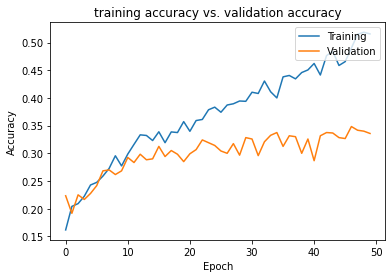

In [62]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [109]:
43.06-32.08

10.980000000000004

In [63]:
# 3. lambda = 0.0005
model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
                    Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.0005))
])

model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 

Epoch 1/50
36/36 - 6s - loss: 1.9107 - sparse_categorical_accuracy: 0.1781 - val_loss: 1.8039 - val_sparse_categorical_accuracy: 0.2133 - 6s/epoch - 179ms/step
Epoch 2/50
36/36 - 6s - loss: 1.7891 - sparse_categorical_accuracy: 0.2139 - val_loss: 1.7714 - val_sparse_categorical_accuracy: 0.2342 - 6s/epoch - 155ms/step
Epoch 3/50
36/36 - 5s - loss: 1.7592 - sparse_categorical_accuracy: 0.2481 - val_loss: 1.7558 - val_sparse_categorical_accuracy: 0.2658 - 5s/epoch - 152ms/step
Epoch 4/50
36/36 - 5s - loss: 1.7093 - sparse_categorical_accuracy: 0.2961 - val_loss: 1.7035 - val_sparse_categorical_accuracy: 0.2742 - 5s/epoch - 153ms/step
Epoch 5/50
36/36 - 10s - loss: 1.6561 - sparse_categorical_accuracy: 0.3211 - val_loss: 1.6870 - val_sparse_categorical_accuracy: 0.3092 - 10s/epoch - 291ms/step
Epoch 6/50
36/36 - 9s - loss: 1.6060 - sparse_categorical_accuracy: 0.3489 - val_loss: 1.6823 - val_sparse_categorical_accuracy: 0.3333 - 9s/epoch - 253ms/step
Epoch 7/50
36/36 - 8s - loss: 1.5621 -

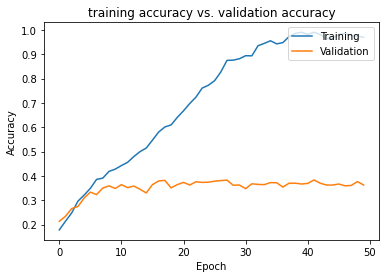

In [64]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [65]:
# 4. lambda = 0.0001
model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 

Epoch 1/50
36/36 - 6s - loss: 1.8223 - sparse_categorical_accuracy: 0.1811 - val_loss: 1.7853 - val_sparse_categorical_accuracy: 0.2492 - 6s/epoch - 167ms/step
Epoch 2/50
36/36 - 6s - loss: 1.7409 - sparse_categorical_accuracy: 0.2689 - val_loss: 1.7208 - val_sparse_categorical_accuracy: 0.2575 - 6s/epoch - 157ms/step
Epoch 3/50
36/36 - 6s - loss: 1.6590 - sparse_categorical_accuracy: 0.3025 - val_loss: 1.6606 - val_sparse_categorical_accuracy: 0.3167 - 6s/epoch - 155ms/step
Epoch 4/50
36/36 - 6s - loss: 1.6182 - sparse_categorical_accuracy: 0.3383 - val_loss: 1.6785 - val_sparse_categorical_accuracy: 0.3083 - 6s/epoch - 154ms/step
Epoch 5/50
36/36 - 5s - loss: 1.5723 - sparse_categorical_accuracy: 0.3631 - val_loss: 1.6331 - val_sparse_categorical_accuracy: 0.3475 - 5s/epoch - 153ms/step
Epoch 6/50
36/36 - 7s - loss: 1.5213 - sparse_categorical_accuracy: 0.3944 - val_loss: 1.6211 - val_sparse_categorical_accuracy: 0.3717 - 7s/epoch - 195ms/step
Epoch 7/50
36/36 - 10s - loss: 1.4704 - 

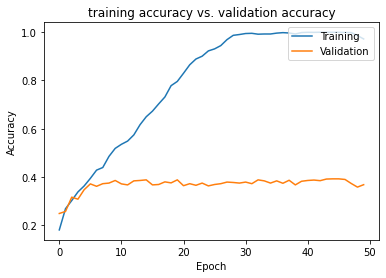

In [66]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [67]:
# 5. lambda = 0.01
model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                    Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.01))
])

model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 

Epoch 1/50
36/36 - 7s - loss: 3.1211 - sparse_categorical_accuracy: 0.1703 - val_loss: 1.8428 - val_sparse_categorical_accuracy: 0.1650 - 7s/epoch - 203ms/step
Epoch 2/50
36/36 - 5s - loss: 1.8054 - sparse_categorical_accuracy: 0.1939 - val_loss: 1.7902 - val_sparse_categorical_accuracy: 0.2083 - 5s/epoch - 151ms/step
Epoch 3/50
36/36 - 6s - loss: 1.7913 - sparse_categorical_accuracy: 0.2011 - val_loss: 1.7954 - val_sparse_categorical_accuracy: 0.1975 - 6s/epoch - 157ms/step
Epoch 4/50
36/36 - 6s - loss: 1.7891 - sparse_categorical_accuracy: 0.2083 - val_loss: 1.7830 - val_sparse_categorical_accuracy: 0.2225 - 6s/epoch - 153ms/step
Epoch 5/50
36/36 - 6s - loss: 1.7846 - sparse_categorical_accuracy: 0.2117 - val_loss: 1.7875 - val_sparse_categorical_accuracy: 0.2058 - 6s/epoch - 158ms/step
Epoch 6/50
36/36 - 6s - loss: 1.7706 - sparse_categorical_accuracy: 0.2364 - val_loss: 1.7750 - val_sparse_categorical_accuracy: 0.2217 - 6s/epoch - 158ms/step
Epoch 7/50
36/36 - 6s - loss: 1.7556 - s

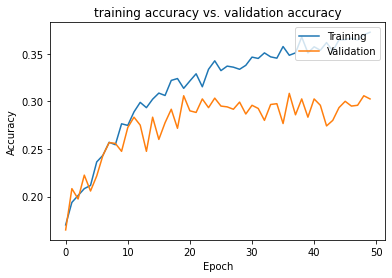

In [68]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

c. Can you improve your validation performance using dropout regularization? Report a table in which you show the validation performance for five different dropout rates.

Epoch 1/50
36/36 - 6s - loss: 1.8008 - sparse_categorical_accuracy: 0.1639 - val_loss: 1.7915 - val_sparse_categorical_accuracy: 0.1667 - 6s/epoch - 171ms/step
Epoch 2/50
36/36 - 6s - loss: 1.7921 - sparse_categorical_accuracy: 0.1586 - val_loss: 1.7918 - val_sparse_categorical_accuracy: 0.1675 - 6s/epoch - 155ms/step
Epoch 3/50
36/36 - 6s - loss: 1.7918 - sparse_categorical_accuracy: 0.1689 - val_loss: 1.7914 - val_sparse_categorical_accuracy: 0.1675 - 6s/epoch - 157ms/step
Epoch 4/50
36/36 - 6s - loss: 1.7911 - sparse_categorical_accuracy: 0.1633 - val_loss: 1.7909 - val_sparse_categorical_accuracy: 0.1758 - 6s/epoch - 162ms/step
Epoch 5/50
36/36 - 6s - loss: 1.7829 - sparse_categorical_accuracy: 0.1931 - val_loss: 1.7797 - val_sparse_categorical_accuracy: 0.1958 - 6s/epoch - 163ms/step
Epoch 6/50
36/36 - 6s - loss: 1.7638 - sparse_categorical_accuracy: 0.2111 - val_loss: 1.7599 - val_sparse_categorical_accuracy: 0.2092 - 6s/epoch - 164ms/step
Epoch 7/50
36/36 - 6s - loss: 1.7384 - s

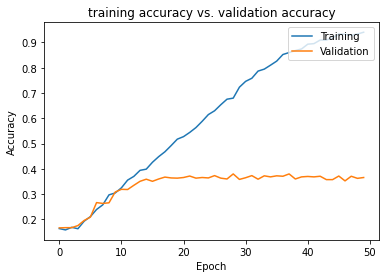

In [69]:
# 1. dropout (0.1)
model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    Dropout(0.1),
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    Dropout(0.1),
                    Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4))
])

model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Epoch 1/50
36/36 - 6s - loss: 1.7959 - sparse_categorical_accuracy: 0.1753 - val_loss: 1.7846 - val_sparse_categorical_accuracy: 0.1908 - 6s/epoch - 176ms/step
Epoch 2/50
36/36 - 7s - loss: 1.7735 - sparse_categorical_accuracy: 0.2269 - val_loss: 1.7554 - val_sparse_categorical_accuracy: 0.2600 - 7s/epoch - 189ms/step
Epoch 3/50
36/36 - 8s - loss: 1.7247 - sparse_categorical_accuracy: 0.2772 - val_loss: 1.6832 - val_sparse_categorical_accuracy: 0.3017 - 8s/epoch - 217ms/step
Epoch 4/50
36/36 - 6s - loss: 1.6701 - sparse_categorical_accuracy: 0.2956 - val_loss: 1.6450 - val_sparse_categorical_accuracy: 0.3283 - 6s/epoch - 170ms/step
Epoch 5/50
36/36 - 5s - loss: 1.6014 - sparse_categorical_accuracy: 0.3442 - val_loss: 1.6133 - val_sparse_categorical_accuracy: 0.3333 - 5s/epoch - 143ms/step
Epoch 6/50
36/36 - 5s - loss: 1.5477 - sparse_categorical_accuracy: 0.3681 - val_loss: 1.5702 - val_sparse_categorical_accuracy: 0.3492 - 5s/epoch - 144ms/step
Epoch 7/50
36/36 - 8s - loss: 1.4976 - s

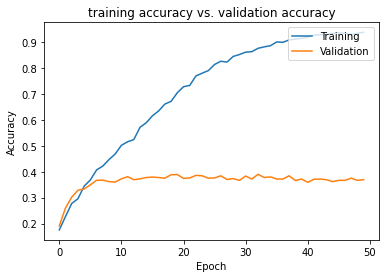

In [70]:
# 2. dropout (0.3)
model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    Dropout(0.3),
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    Dropout(0.3),
                    Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4))
])

model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Epoch 1/50
36/36 - 6s - loss: 1.8046 - sparse_categorical_accuracy: 0.1625 - val_loss: 1.7912 - val_sparse_categorical_accuracy: 0.1508 - 6s/epoch - 160ms/step
Epoch 2/50
36/36 - 5s - loss: 1.7917 - sparse_categorical_accuracy: 0.1686 - val_loss: 1.7896 - val_sparse_categorical_accuracy: 0.1783 - 5s/epoch - 140ms/step
Epoch 3/50
36/36 - 5s - loss: 1.7893 - sparse_categorical_accuracy: 0.1867 - val_loss: 1.7881 - val_sparse_categorical_accuracy: 0.1875 - 5s/epoch - 145ms/step
Epoch 4/50
36/36 - 5s - loss: 1.7879 - sparse_categorical_accuracy: 0.1936 - val_loss: 1.7806 - val_sparse_categorical_accuracy: 0.2050 - 5s/epoch - 150ms/step
Epoch 5/50
36/36 - 6s - loss: 1.7704 - sparse_categorical_accuracy: 0.2114 - val_loss: 1.7598 - val_sparse_categorical_accuracy: 0.2175 - 6s/epoch - 156ms/step
Epoch 6/50
36/36 - 6s - loss: 1.7534 - sparse_categorical_accuracy: 0.2317 - val_loss: 1.7317 - val_sparse_categorical_accuracy: 0.2608 - 6s/epoch - 154ms/step
Epoch 7/50
36/36 - 5s - loss: 1.7183 - s

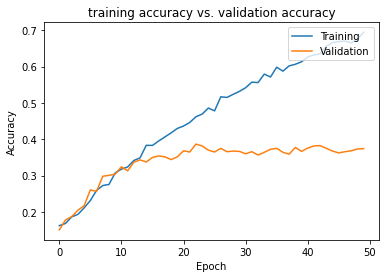

In [71]:
# 3. dropout (0.5)
model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    Dropout(0.5),
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    Dropout(0.5),
                    Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4))
])

model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Epoch 1/50
36/36 - 6s - loss: 1.8063 - sparse_categorical_accuracy: 0.1672 - val_loss: 1.7916 - val_sparse_categorical_accuracy: 0.1650 - 6s/epoch - 154ms/step
Epoch 2/50
36/36 - 5s - loss: 1.7934 - sparse_categorical_accuracy: 0.1736 - val_loss: 1.7916 - val_sparse_categorical_accuracy: 0.1583 - 5s/epoch - 136ms/step
Epoch 3/50
36/36 - 5s - loss: 1.7923 - sparse_categorical_accuracy: 0.1742 - val_loss: 1.7911 - val_sparse_categorical_accuracy: 0.2108 - 5s/epoch - 138ms/step
Epoch 4/50
36/36 - 5s - loss: 1.7954 - sparse_categorical_accuracy: 0.1661 - val_loss: 1.7919 - val_sparse_categorical_accuracy: 0.1667 - 5s/epoch - 136ms/step
Epoch 5/50
36/36 - 5s - loss: 1.7942 - sparse_categorical_accuracy: 0.1644 - val_loss: 1.7908 - val_sparse_categorical_accuracy: 0.1608 - 5s/epoch - 139ms/step
Epoch 6/50
36/36 - 5s - loss: 1.7942 - sparse_categorical_accuracy: 0.1583 - val_loss: 1.7905 - val_sparse_categorical_accuracy: 0.1867 - 5s/epoch - 140ms/step
Epoch 7/50
36/36 - 5s - loss: 1.7933 - s

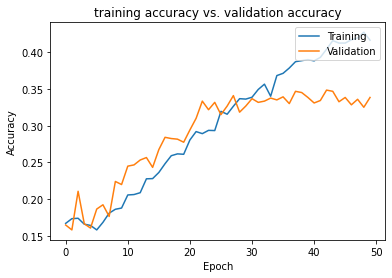

In [72]:
# 4. dropout (0.7)
model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    Dropout(0.7),
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    Dropout(0.7),
                    Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4))
])

model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Epoch 1/50
36/36 - 8s - loss: 1.8784 - sparse_categorical_accuracy: 0.1744 - val_loss: 1.7918 - val_sparse_categorical_accuracy: 0.1667 - 8s/epoch - 228ms/step
Epoch 2/50
36/36 - 7s - loss: 1.7964 - sparse_categorical_accuracy: 0.1692 - val_loss: 1.7919 - val_sparse_categorical_accuracy: 0.1675 - 7s/epoch - 197ms/step
Epoch 3/50
36/36 - 5s - loss: 1.7988 - sparse_categorical_accuracy: 0.1661 - val_loss: 1.7918 - val_sparse_categorical_accuracy: 0.1667 - 5s/epoch - 137ms/step
Epoch 4/50
36/36 - 5s - loss: 1.7962 - sparse_categorical_accuracy: 0.1689 - val_loss: 1.7918 - val_sparse_categorical_accuracy: 0.1600 - 5s/epoch - 132ms/step
Epoch 5/50
36/36 - 5s - loss: 1.7939 - sparse_categorical_accuracy: 0.1739 - val_loss: 1.7918 - val_sparse_categorical_accuracy: 0.1675 - 5s/epoch - 132ms/step
Epoch 6/50
36/36 - 5s - loss: 1.7947 - sparse_categorical_accuracy: 0.1658 - val_loss: 1.7918 - val_sparse_categorical_accuracy: 0.1675 - 5s/epoch - 132ms/step
Epoch 7/50
36/36 - 5s - loss: 1.7929 - s

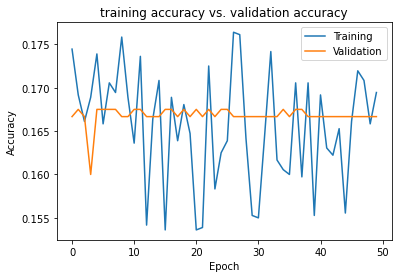

In [73]:
# 5. dropout (0.9)
model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    Dropout(0.9),
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    Dropout(0.9),
                    Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4))
])

model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

d. Can you improve your validation performance using a mixture of dropout regularization and L2 regularization? Report a table in which you show the validation performance for five different combinations.

Epoch 1/50
36/36 - 6s - loss: 2.2529 - sparse_categorical_accuracy: 0.1592 - val_loss: 1.8456 - val_sparse_categorical_accuracy: 0.1592 - 6s/epoch - 176ms/step
Epoch 2/50
36/36 - 5s - loss: 1.8180 - sparse_categorical_accuracy: 0.1756 - val_loss: 1.8021 - val_sparse_categorical_accuracy: 0.1850 - 5s/epoch - 145ms/step
Epoch 3/50
36/36 - 5s - loss: 1.8000 - sparse_categorical_accuracy: 0.1756 - val_loss: 1.7976 - val_sparse_categorical_accuracy: 0.1717 - 5s/epoch - 150ms/step
Epoch 4/50
36/36 - 7s - loss: 1.7993 - sparse_categorical_accuracy: 0.1619 - val_loss: 1.7967 - val_sparse_categorical_accuracy: 0.1933 - 7s/epoch - 204ms/step
Epoch 5/50
36/36 - 7s - loss: 1.7986 - sparse_categorical_accuracy: 0.1725 - val_loss: 1.7959 - val_sparse_categorical_accuracy: 0.1850 - 7s/epoch - 205ms/step
Epoch 6/50
36/36 - 8s - loss: 1.7985 - sparse_categorical_accuracy: 0.1739 - val_loss: 1.7961 - val_sparse_categorical_accuracy: 0.2075 - 8s/epoch - 215ms/step
Epoch 7/50
36/36 - 5s - loss: 1.7971 - s

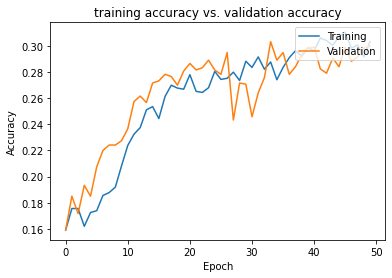

In [74]:
# 1. lambda = 0.002 / dropout (0.7)
model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.002)),
                    Dropout(0.7),
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.002)),
                    Dropout(0.7),
                    Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.002))
])

model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Epoch 1/50
36/36 - 6s - loss: 2.2234 - sparse_categorical_accuracy: 0.1744 - val_loss: 1.8485 - val_sparse_categorical_accuracy: 0.1383 - 6s/epoch - 180ms/step
Epoch 2/50
36/36 - 6s - loss: 1.8218 - sparse_categorical_accuracy: 0.1750 - val_loss: 1.8054 - val_sparse_categorical_accuracy: 0.1667 - 6s/epoch - 155ms/step
Epoch 3/50
36/36 - 6s - loss: 1.8049 - sparse_categorical_accuracy: 0.1678 - val_loss: 1.7995 - val_sparse_categorical_accuracy: 0.1617 - 6s/epoch - 155ms/step
Epoch 4/50
36/36 - 6s - loss: 1.8008 - sparse_categorical_accuracy: 0.1706 - val_loss: 1.7986 - val_sparse_categorical_accuracy: 0.2000 - 6s/epoch - 155ms/step
Epoch 5/50
36/36 - 6s - loss: 1.7988 - sparse_categorical_accuracy: 0.1661 - val_loss: 1.7957 - val_sparse_categorical_accuracy: 0.1700 - 6s/epoch - 157ms/step
Epoch 6/50
36/36 - 6s - loss: 1.7959 - sparse_categorical_accuracy: 0.1789 - val_loss: 1.7948 - val_sparse_categorical_accuracy: 0.1683 - 6s/epoch - 158ms/step
Epoch 7/50
36/36 - 6s - loss: 1.7980 - s

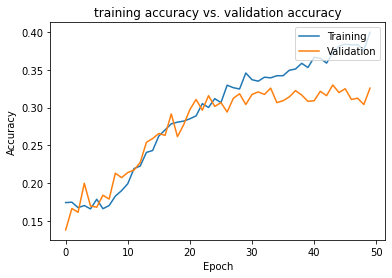

In [76]:
# 2. lambda = 0.002 / dropout (0.5)
model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.002)),
                    Dropout(0.5),
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.002)),
                    Dropout(0.5),
                    Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.002))
])

model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Epoch 1/50
36/36 - 10s - loss: 2.2888 - sparse_categorical_accuracy: 0.1653 - val_loss: 1.8237 - val_sparse_categorical_accuracy: 0.1667 - 10s/epoch - 273ms/step
Epoch 2/50
36/36 - 5s - loss: 1.8071 - sparse_categorical_accuracy: 0.1744 - val_loss: 1.7991 - val_sparse_categorical_accuracy: 0.1667 - 5s/epoch - 138ms/step
Epoch 3/50
36/36 - 5s - loss: 1.8002 - sparse_categorical_accuracy: 0.1753 - val_loss: 1.7988 - val_sparse_categorical_accuracy: 0.1850 - 5s/epoch - 138ms/step
Epoch 4/50
36/36 - 6s - loss: 1.7993 - sparse_categorical_accuracy: 0.1742 - val_loss: 1.7966 - val_sparse_categorical_accuracy: 0.2075 - 6s/epoch - 171ms/step
Epoch 5/50
36/36 - 5s - loss: 1.8022 - sparse_categorical_accuracy: 0.1808 - val_loss: 1.7976 - val_sparse_categorical_accuracy: 0.1942 - 5s/epoch - 145ms/step
Epoch 6/50
36/36 - 5s - loss: 1.8003 - sparse_categorical_accuracy: 0.1869 - val_loss: 1.7933 - val_sparse_categorical_accuracy: 0.2092 - 5s/epoch - 144ms/step
Epoch 7/50
36/36 - 5s - loss: 1.7957 -

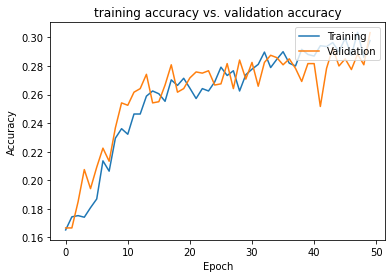

In [78]:
# 3. lambda = 0.003 / dropout (0.7)
model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.003)),
                    Dropout(0.7),
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.003)),
                    Dropout(0.7),
                    Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.003))
])

model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Epoch 1/50
36/36 - 6s - loss: 2.3426 - sparse_categorical_accuracy: 0.1522 - val_loss: 1.8253 - val_sparse_categorical_accuracy: 0.1733 - 6s/epoch - 171ms/step
Epoch 2/50
36/36 - 5s - loss: 1.8096 - sparse_categorical_accuracy: 0.1583 - val_loss: 1.8009 - val_sparse_categorical_accuracy: 0.1875 - 5s/epoch - 152ms/step
Epoch 3/50
36/36 - 6s - loss: 1.7988 - sparse_categorical_accuracy: 0.1789 - val_loss: 1.7989 - val_sparse_categorical_accuracy: 0.1683 - 6s/epoch - 153ms/step
Epoch 4/50
36/36 - 5s - loss: 1.7995 - sparse_categorical_accuracy: 0.1767 - val_loss: 1.7992 - val_sparse_categorical_accuracy: 0.1667 - 5s/epoch - 151ms/step
Epoch 5/50
36/36 - 6s - loss: 1.7989 - sparse_categorical_accuracy: 0.1653 - val_loss: 1.7978 - val_sparse_categorical_accuracy: 0.1800 - 6s/epoch - 171ms/step
Epoch 6/50
36/36 - 9s - loss: 1.7999 - sparse_categorical_accuracy: 0.1658 - val_loss: 1.7983 - val_sparse_categorical_accuracy: 0.1667 - 9s/epoch - 244ms/step
Epoch 7/50
36/36 - 8s - loss: 1.7995 - s

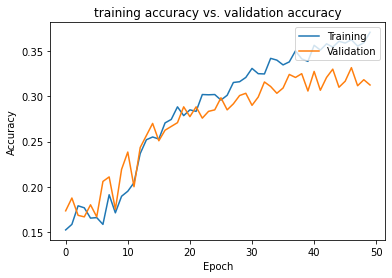

In [79]:
# 4. lambda = 0.003 / dropout (0.5)
model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.003)),
                    Dropout(0.5),
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.003)),
                    Dropout(0.5),
                    Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.003))
])

model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Epoch 1/50
36/36 - 6s - loss: 1.9912 - sparse_categorical_accuracy: 0.1692 - val_loss: 1.8598 - val_sparse_categorical_accuracy: 0.1683 - 6s/epoch - 175ms/step
Epoch 2/50
36/36 - 5s - loss: 1.8400 - sparse_categorical_accuracy: 0.1656 - val_loss: 1.8214 - val_sparse_categorical_accuracy: 0.1667 - 5s/epoch - 149ms/step
Epoch 3/50
36/36 - 6s - loss: 1.8151 - sparse_categorical_accuracy: 0.1722 - val_loss: 1.8085 - val_sparse_categorical_accuracy: 0.1617 - 6s/epoch - 178ms/step
Epoch 4/50
36/36 - 5s - loss: 1.8059 - sparse_categorical_accuracy: 0.1697 - val_loss: 1.8017 - val_sparse_categorical_accuracy: 0.1758 - 5s/epoch - 147ms/step
Epoch 5/50
36/36 - 5s - loss: 1.8032 - sparse_categorical_accuracy: 0.1608 - val_loss: 1.7984 - val_sparse_categorical_accuracy: 0.1658 - 5s/epoch - 148ms/step
Epoch 6/50
36/36 - 5s - loss: 1.7991 - sparse_categorical_accuracy: 0.1636 - val_loss: 1.7970 - val_sparse_categorical_accuracy: 0.1658 - 5s/epoch - 146ms/step
Epoch 7/50
36/36 - 5s - loss: 1.7973 - s

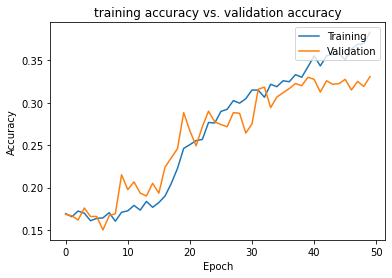

In [81]:
# 5. lambda = 0.0005 / dropout (0.7)
model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
                    Dropout(0.7),
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
                    Dropout(0.7),
                    Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.0005))
])

model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# 6. lambda = 0.001 / dropout (0.3)
model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
                    Dropout(0.7),
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
                    Dropout(0.7),
                    Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.0005))
])

model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

e. Can you improve your validation performance using batch-normalization? Report a table in which you show the validation performance for five different batch- normalizations (one model with default TF batch-normalization parameters and four models with customized parameters).

Epoch 1/50
36/36 - 7s - loss: 1.7106 - sparse_categorical_accuracy: 0.2650 - val_loss: 1.7348 - val_sparse_categorical_accuracy: 0.2858 - 7s/epoch - 184ms/step
Epoch 2/50
36/36 - 5s - loss: 1.5232 - sparse_categorical_accuracy: 0.3903 - val_loss: 1.7270 - val_sparse_categorical_accuracy: 0.2042 - 5s/epoch - 152ms/step
Epoch 3/50
36/36 - 5s - loss: 1.3364 - sparse_categorical_accuracy: 0.4883 - val_loss: 1.6672 - val_sparse_categorical_accuracy: 0.2658 - 5s/epoch - 152ms/step
Epoch 4/50
36/36 - 5s - loss: 1.1637 - sparse_categorical_accuracy: 0.5683 - val_loss: 1.7260 - val_sparse_categorical_accuracy: 0.2733 - 5s/epoch - 151ms/step
Epoch 5/50
36/36 - 5s - loss: 0.9815 - sparse_categorical_accuracy: 0.6433 - val_loss: 1.6503 - val_sparse_categorical_accuracy: 0.3333 - 5s/epoch - 149ms/step
Epoch 6/50
36/36 - 5s - loss: 0.8111 - sparse_categorical_accuracy: 0.7219 - val_loss: 2.0852 - val_sparse_categorical_accuracy: 0.2450 - 5s/epoch - 150ms/step
Epoch 7/50
36/36 - 5s - loss: 0.6541 - s

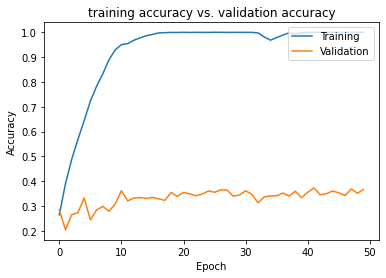

In [82]:
# 1. TF batch-normallization
model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    BatchNormalization(), # <- Batch normalization layer 1
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    BatchNormalization(), # <- Batch normalization layer 2
                    Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4))
])

model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Epoch 1/50
36/36 - 11s - loss: 1.7143 - sparse_categorical_accuracy: 0.2678 - val_loss: 1.7009 - val_sparse_categorical_accuracy: 0.2900 - 11s/epoch - 314ms/step
Epoch 2/50
36/36 - 6s - loss: 1.5241 - sparse_categorical_accuracy: 0.3789 - val_loss: 1.5765 - val_sparse_categorical_accuracy: 0.3458 - 6s/epoch - 158ms/step
Epoch 3/50
36/36 - 6s - loss: 1.3397 - sparse_categorical_accuracy: 0.4842 - val_loss: 1.6126 - val_sparse_categorical_accuracy: 0.3483 - 6s/epoch - 156ms/step
Epoch 4/50
36/36 - 6s - loss: 1.1728 - sparse_categorical_accuracy: 0.5644 - val_loss: 1.9189 - val_sparse_categorical_accuracy: 0.2983 - 6s/epoch - 153ms/step
Epoch 5/50
36/36 - 5s - loss: 0.9953 - sparse_categorical_accuracy: 0.6400 - val_loss: 1.9158 - val_sparse_categorical_accuracy: 0.2758 - 5s/epoch - 151ms/step
Epoch 6/50
36/36 - 5s - loss: 0.8451 - sparse_categorical_accuracy: 0.6942 - val_loss: 2.2358 - val_sparse_categorical_accuracy: 0.2975 - 5s/epoch - 150ms/step
Epoch 7/50
36/36 - 5s - loss: 0.6941 -

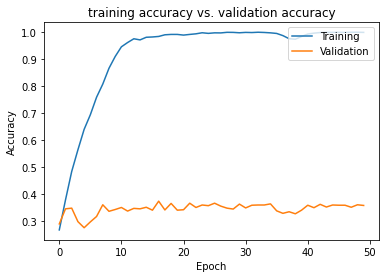

In [84]:
# 2. customized parameters 1

model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    BatchNormalization(), # <- Batch normalization layer 1
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    #BatchNormalization(), # <- Batch normalization layer 2
                    #Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                    #      bias_initializer=tf.keras.initializers.Constant(value=0.4))
])

# Add a customised batch normalization layer 2
model.add(tf.keras.layers.BatchNormalization(
    momentum=0.95, # default is 0.99
    epsilon=0.005, #default is 0.001
    axis = -1, #default is -1
    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), # default is beta_initializer='zeros'
    gamma_initializer=tf.keras.initializers.Constant(value=0.9) # default is gamma_initializer='ones'
))

# Add the output layer
model.add(Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4)))

model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Epoch 1/50
36/36 - 6s - loss: 1.7382 - sparse_categorical_accuracy: 0.2489 - val_loss: 2.2361 - val_sparse_categorical_accuracy: 0.1683 - 6s/epoch - 179ms/step
Epoch 2/50
36/36 - 6s - loss: 1.5632 - sparse_categorical_accuracy: 0.3631 - val_loss: 1.9205 - val_sparse_categorical_accuracy: 0.2158 - 6s/epoch - 164ms/step
Epoch 3/50
36/36 - 6s - loss: 1.4186 - sparse_categorical_accuracy: 0.4394 - val_loss: 1.9357 - val_sparse_categorical_accuracy: 0.2375 - 6s/epoch - 163ms/step
Epoch 4/50
36/36 - 6s - loss: 1.2833 - sparse_categorical_accuracy: 0.5103 - val_loss: 1.7470 - val_sparse_categorical_accuracy: 0.3433 - 6s/epoch - 164ms/step
Epoch 5/50
36/36 - 6s - loss: 1.1575 - sparse_categorical_accuracy: 0.5617 - val_loss: 1.7386 - val_sparse_categorical_accuracy: 0.3092 - 6s/epoch - 163ms/step
Epoch 6/50
36/36 - 6s - loss: 1.0031 - sparse_categorical_accuracy: 0.6308 - val_loss: 2.5004 - val_sparse_categorical_accuracy: 0.2525 - 6s/epoch - 163ms/step
Epoch 7/50
36/36 - 6s - loss: 0.8719 - s

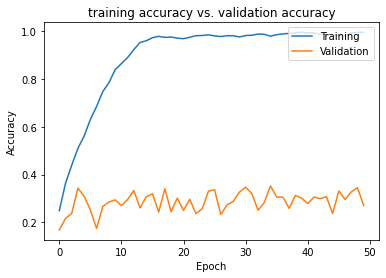

In [85]:
# 3. customized parameters 2

model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    BatchNormalization(), # <- Batch normalization layer 1
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    #BatchNormalization(), # <- Batch normalization layer 2
                    #Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                    #      bias_initializer=tf.keras.initializers.Constant(value=0.4))
])

# Add a customised batch normalization layer 2
model.add(tf.keras.layers.BatchNormalization(
    momentum=0.9, # default is 0.99
    epsilon=0.005, #default is 0.001
    axis = -1, #default is -1
    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), # default is beta_initializer='zeros'
    gamma_initializer=tf.keras.initializers.Constant(value=0.9) # default is gamma_initializer='ones'
))

# Add the output layer
model.add(Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4)))


model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Epoch 1/50
36/36 - 10s - loss: 1.7295 - sparse_categorical_accuracy: 0.2403 - val_loss: 1.7354 - val_sparse_categorical_accuracy: 0.2458 - 10s/epoch - 269ms/step
Epoch 2/50
36/36 - 5s - loss: 1.5611 - sparse_categorical_accuracy: 0.3617 - val_loss: 1.8164 - val_sparse_categorical_accuracy: 0.2417 - 5s/epoch - 144ms/step
Epoch 3/50
36/36 - 5s - loss: 1.4000 - sparse_categorical_accuracy: 0.4539 - val_loss: 1.7508 - val_sparse_categorical_accuracy: 0.2683 - 5s/epoch - 141ms/step
Epoch 4/50
36/36 - 5s - loss: 1.2269 - sparse_categorical_accuracy: 0.5394 - val_loss: 1.7014 - val_sparse_categorical_accuracy: 0.3108 - 5s/epoch - 137ms/step
Epoch 5/50
36/36 - 5s - loss: 1.0423 - sparse_categorical_accuracy: 0.6217 - val_loss: 1.6142 - val_sparse_categorical_accuracy: 0.3567 - 5s/epoch - 139ms/step
Epoch 6/50
36/36 - 5s - loss: 0.8522 - sparse_categorical_accuracy: 0.6953 - val_loss: 2.0125 - val_sparse_categorical_accuracy: 0.3067 - 5s/epoch - 138ms/step
Epoch 7/50
36/36 - 5s - loss: 0.6746 -

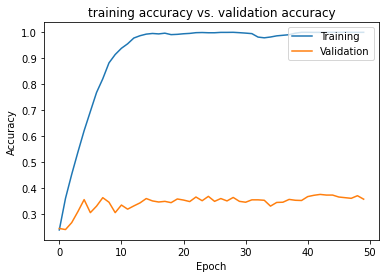

In [87]:
# 4. customized parameters 3

model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    BatchNormalization(), # <- Batch normalization layer 1
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    #BatchNormalization(), # <- Batch normalization layer 2
                    #Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                    #      bias_initializer=tf.keras.initializers.Constant(value=0.4))
])

# Add a customised batch normalization layer 2
model.add(tf.keras.layers.BatchNormalization(
    momentum=0.95, # default is 0.99
    epsilon=0.0005, #default is 0.001
    axis = -1, #default is -1
    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), # default is beta_initializer='zeros'
    gamma_initializer=tf.keras.initializers.Constant(value=0.9) # default is gamma_initializer='ones'
))

# Add the output layer
model.add(Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4)))


model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Epoch 1/50
36/36 - 6s - loss: 1.6951 - sparse_categorical_accuracy: 0.2800 - val_loss: 1.6869 - val_sparse_categorical_accuracy: 0.2908 - 6s/epoch - 172ms/step
Epoch 2/50
36/36 - 5s - loss: 1.4940 - sparse_categorical_accuracy: 0.4069 - val_loss: 1.5779 - val_sparse_categorical_accuracy: 0.3583 - 5s/epoch - 146ms/step
Epoch 3/50
36/36 - 5s - loss: 1.3237 - sparse_categorical_accuracy: 0.4908 - val_loss: 1.6315 - val_sparse_categorical_accuracy: 0.3258 - 5s/epoch - 146ms/step
Epoch 4/50
36/36 - 5s - loss: 1.1780 - sparse_categorical_accuracy: 0.5631 - val_loss: 1.7492 - val_sparse_categorical_accuracy: 0.3317 - 5s/epoch - 144ms/step
Epoch 5/50
36/36 - 5s - loss: 1.0169 - sparse_categorical_accuracy: 0.6306 - val_loss: 1.7704 - val_sparse_categorical_accuracy: 0.3558 - 5s/epoch - 142ms/step
Epoch 6/50
36/36 - 5s - loss: 0.8395 - sparse_categorical_accuracy: 0.6939 - val_loss: 1.9306 - val_sparse_categorical_accuracy: 0.3258 - 5s/epoch - 142ms/step
Epoch 7/50
36/36 - 5s - loss: 0.6493 - s

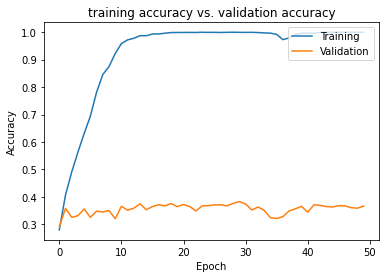

In [88]:
# 5. customized parameters 4

model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    BatchNormalization(), # <- Batch normalization layer 1
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    #BatchNormalization(), # <- Batch normalization layer 2
                    #Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                    #      bias_initializer=tf.keras.initializers.Constant(value=0.4))
])

# Add a customised batch normalization layer 2
model.add(tf.keras.layers.BatchNormalization(
    momentum=0.95, # default is 0.99
    epsilon=0.0005, #default is 0.001
    axis = -1, #default is -1
    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), # default is beta_initializer='zeros'
    gamma_initializer=tf.keras.initializers.Constant(value=0.5) # default is gamma_initializer='ones'
))

# Add the output layer
model.add(Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4)))


model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 10, batch_size = 100, verbose = 2,validation_split=0.25) 
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

f. Can you improve your validation performance using a mixture of batch- normalization and dropout regularization? Report a table in which you show the validation performance for five different combinations.

Epoch 1/50
36/36 - 11s - loss: 1.7516 - sparse_categorical_accuracy: 0.2256 - val_loss: 1.7738 - val_sparse_categorical_accuracy: 0.1917 - 11s/epoch - 316ms/step
Epoch 2/50
36/36 - 7s - loss: 1.6117 - sparse_categorical_accuracy: 0.3425 - val_loss: 1.7234 - val_sparse_categorical_accuracy: 0.2858 - 7s/epoch - 194ms/step
Epoch 3/50
36/36 - 5s - loss: 1.4762 - sparse_categorical_accuracy: 0.4139 - val_loss: 1.9591 - val_sparse_categorical_accuracy: 0.2908 - 5s/epoch - 143ms/step
Epoch 4/50
36/36 - 5s - loss: 1.3545 - sparse_categorical_accuracy: 0.4869 - val_loss: 2.3459 - val_sparse_categorical_accuracy: 0.2558 - 5s/epoch - 142ms/step
Epoch 5/50
36/36 - 5s - loss: 1.2460 - sparse_categorical_accuracy: 0.5244 - val_loss: 1.9351 - val_sparse_categorical_accuracy: 0.2883 - 5s/epoch - 140ms/step
Epoch 6/50
36/36 - 5s - loss: 1.1545 - sparse_categorical_accuracy: 0.5656 - val_loss: 2.4465 - val_sparse_categorical_accuracy: 0.2133 - 5s/epoch - 140ms/step
Epoch 7/50
36/36 - 5s - loss: 1.0478 -

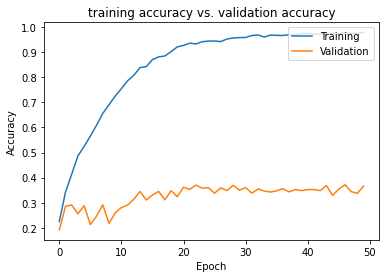

In [108]:
# 1. dropout = 0.3 / customized parameters 1

model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    BatchNormalization(), # <- Batch normalization layer 1
                    Dropout(0.3),
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    #BatchNormalization(), # <- Batch normalization layer 2
                    #Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                    #      bias_initializer=tf.keras.initializers.Constant(value=0.4))
])

# Add a customised batch normalization layer 2
model.add(tf.keras.layers.BatchNormalization(
    momentum=0.95, # default is 0.99
    epsilon=0.0005, #default is 0.001
    axis = -1, #default is -1
    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), # default is beta_initializer='zeros'
    gamma_initializer=tf.keras.initializers.Constant(value=0.5) # default is gamma_initializer='ones'
))

# Add the output layer
model.add(Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4)))



model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Epoch 1/50
36/36 - 11s - loss: 1.7662 - sparse_categorical_accuracy: 0.2142 - val_loss: 1.8546 - val_sparse_categorical_accuracy: 0.1667 - 11s/epoch - 309ms/step
Epoch 2/50
36/36 - 9s - loss: 1.7205 - sparse_categorical_accuracy: 0.2656 - val_loss: 1.9356 - val_sparse_categorical_accuracy: 0.1992 - 9s/epoch - 251ms/step
Epoch 3/50
36/36 - 8s - loss: 1.6330 - sparse_categorical_accuracy: 0.3147 - val_loss: 2.0882 - val_sparse_categorical_accuracy: 0.1967 - 8s/epoch - 232ms/step
Epoch 4/50
36/36 - 8s - loss: 1.5467 - sparse_categorical_accuracy: 0.3667 - val_loss: 2.3430 - val_sparse_categorical_accuracy: 0.1675 - 8s/epoch - 230ms/step
Epoch 5/50
36/36 - 8s - loss: 1.4878 - sparse_categorical_accuracy: 0.4000 - val_loss: 2.2030 - val_sparse_categorical_accuracy: 0.1858 - 8s/epoch - 219ms/step
Epoch 6/50
36/36 - 10s - loss: 1.4341 - sparse_categorical_accuracy: 0.4369 - val_loss: 2.0262 - val_sparse_categorical_accuracy: 0.2358 - 10s/epoch - 266ms/step
Epoch 7/50
36/36 - 8s - loss: 1.3742

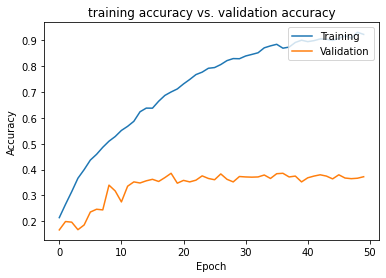

In [110]:
# 2. dropout = 0.5 / customized parameters 2

model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    BatchNormalization(), # <- Batch normalization layer 1
                    Dropout(0.5),
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    #BatchNormalization(), # <- Batch normalization layer 2
                    #Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                    #      bias_initializer=tf.keras.initializers.Constant(value=0.4))
])

# Add a customised batch normalization layer 2
model.add(tf.keras.layers.BatchNormalization(
    momentum=0.95, # default is 0.99
    epsilon=0.0001, #default is 0.001
    axis = -1, #default is -1
    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), # default is beta_initializer='zeros'
    gamma_initializer=tf.keras.initializers.Constant(value=0.5) # default is gamma_initializer='ones'
))

# Add the output layer
model.add(Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4)))


model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Epoch 1/50
36/36 - 6s - loss: 1.7533 - sparse_categorical_accuracy: 0.2319 - val_loss: 1.8270 - val_sparse_categorical_accuracy: 0.2183 - 6s/epoch - 171ms/step
Epoch 2/50
36/36 - 5s - loss: 1.6290 - sparse_categorical_accuracy: 0.3200 - val_loss: 1.7742 - val_sparse_categorical_accuracy: 0.2558 - 5s/epoch - 143ms/step
Epoch 3/50
36/36 - 5s - loss: 1.5290 - sparse_categorical_accuracy: 0.3856 - val_loss: 1.6859 - val_sparse_categorical_accuracy: 0.2800 - 5s/epoch - 143ms/step
Epoch 4/50
36/36 - 5s - loss: 1.4416 - sparse_categorical_accuracy: 0.4331 - val_loss: 1.7930 - val_sparse_categorical_accuracy: 0.2833 - 5s/epoch - 141ms/step
Epoch 5/50
36/36 - 5s - loss: 1.3428 - sparse_categorical_accuracy: 0.4772 - val_loss: 1.7402 - val_sparse_categorical_accuracy: 0.2967 - 5s/epoch - 142ms/step
Epoch 6/50
36/36 - 5s - loss: 1.2927 - sparse_categorical_accuracy: 0.5150 - val_loss: 1.6854 - val_sparse_categorical_accuracy: 0.3225 - 5s/epoch - 140ms/step
Epoch 7/50
36/36 - 5s - loss: 1.2111 - s

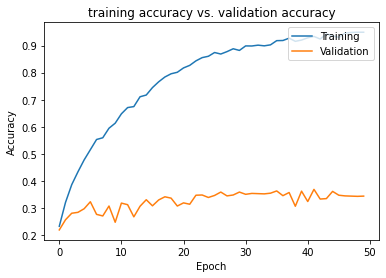

In [119]:
# 3. dropout = 0.5 / customized parameters 3

model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    BatchNormalization(), # <- Batch normalization layer 1
                    Dropout(0.5),
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    #BatchNormalization(), # <- Batch normalization layer 2
                    #Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                    #      bias_initializer=tf.keras.initializers.Constant(value=0.4))
])

# Add a customised batch normalization layer 2
model.add(tf.keras.layers.BatchNormalization(
    momentum=0.95, # default is 0.99
    epsilon=0.0001, #default is 0.001
    axis = -1, #default is -1
    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), # default is beta_initializer='zeros'
    gamma_initializer=tf.keras.initializers.Constant(value=0.9) # default is gamma_initializer='ones'
))

# Add the output layer
model.add(Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4)))

model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Epoch 1/50
36/36 - 6s - loss: 1.7623 - sparse_categorical_accuracy: 0.2183 - val_loss: 1.9199 - val_sparse_categorical_accuracy: 0.1675 - 6s/epoch - 173ms/step
Epoch 2/50
36/36 - 5s - loss: 1.6761 - sparse_categorical_accuracy: 0.2922 - val_loss: 1.8983 - val_sparse_categorical_accuracy: 0.1758 - 5s/epoch - 145ms/step
Epoch 3/50
36/36 - 5s - loss: 1.5911 - sparse_categorical_accuracy: 0.3528 - val_loss: 1.8202 - val_sparse_categorical_accuracy: 0.2542 - 5s/epoch - 142ms/step
Epoch 4/50
36/36 - 5s - loss: 1.5205 - sparse_categorical_accuracy: 0.3967 - val_loss: 2.0035 - val_sparse_categorical_accuracy: 0.2483 - 5s/epoch - 144ms/step
Epoch 5/50
36/36 - 5s - loss: 1.4970 - sparse_categorical_accuracy: 0.3981 - val_loss: 1.7932 - val_sparse_categorical_accuracy: 0.2992 - 5s/epoch - 143ms/step
Epoch 6/50
36/36 - 5s - loss: 1.4634 - sparse_categorical_accuracy: 0.4258 - val_loss: 1.7707 - val_sparse_categorical_accuracy: 0.3017 - 5s/epoch - 143ms/step
Epoch 7/50
36/36 - 5s - loss: 1.4436 - s

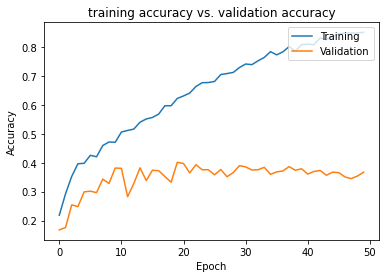

In [112]:
# 4. dropout = 0.7 / customized parameters 1

model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    BatchNormalization(), # <- Batch normalization layer 1
                    Dropout(0.7),
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    #BatchNormalization(), # <- Batch normalization layer 2
                    #Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                    #      bias_initializer=tf.keras.initializers.Constant(value=0.4))
])

# Add a customised batch normalization layer 2
model.add(tf.keras.layers.BatchNormalization(
    momentum=0.95, # default is 0.99
    epsilon=0.005, #default is 0.001
    axis = -1, #default is -1
    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), # default is beta_initializer='zeros'
    gamma_initializer=tf.keras.initializers.Constant(value=0.9) # default is gamma_initializer='ones'
))

# Add the output layer
model.add(Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4)))


model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Epoch 1/50
36/36 - 6s - loss: 1.7633 - sparse_categorical_accuracy: 0.2244 - val_loss: 2.0884 - val_sparse_categorical_accuracy: 0.1667 - 6s/epoch - 174ms/step
Epoch 2/50
36/36 - 5s - loss: 1.7225 - sparse_categorical_accuracy: 0.2575 - val_loss: 1.7901 - val_sparse_categorical_accuracy: 0.1750 - 5s/epoch - 151ms/step
Epoch 3/50
36/36 - 5s - loss: 1.6604 - sparse_categorical_accuracy: 0.3033 - val_loss: 1.8720 - val_sparse_categorical_accuracy: 0.2233 - 5s/epoch - 150ms/step
Epoch 4/50
36/36 - 5s - loss: 1.6012 - sparse_categorical_accuracy: 0.3347 - val_loss: 1.9271 - val_sparse_categorical_accuracy: 0.2158 - 5s/epoch - 140ms/step
Epoch 5/50
36/36 - 5s - loss: 1.5377 - sparse_categorical_accuracy: 0.3825 - val_loss: 2.2015 - val_sparse_categorical_accuracy: 0.1725 - 5s/epoch - 138ms/step
Epoch 6/50
36/36 - 5s - loss: 1.5029 - sparse_categorical_accuracy: 0.3986 - val_loss: 2.2083 - val_sparse_categorical_accuracy: 0.1692 - 5s/epoch - 141ms/step
Epoch 7/50
36/36 - 5s - loss: 1.4675 - s

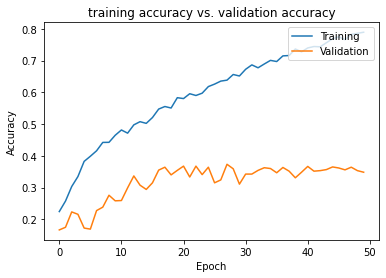

In [113]:
# 5. dropout = 0.7 / customized parameters 2

model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    BatchNormalization(), # <- Batch normalization layer 1
                    Dropout(0.7),
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4)),
                    #BatchNormalization(), # <- Batch normalization layer 2
                    #Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                    #      bias_initializer=tf.keras.initializers.Constant(value=0.4))
])

# Add a customised batch normalization layer 2
model.add(tf.keras.layers.BatchNormalization(
    momentum=0.95, # default is 0.99
    epsilon=0.0005, #default is 0.001
    axis = -1, #default is -1
    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), # default is beta_initializer='zeros'
    gamma_initializer=tf.keras.initializers.Constant(value=0.9) # default is gamma_initializer='ones'
))

# Add the output layer
model.add(Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4)))


model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

g. Can you improve your validation performance using a mixture of batch- normalization, dropout regularization and L2 regularization? Report a table in which you show the validation performance for five different combinations.

Epoch 1/50
36/36 - 7s - loss: 2.0014 - sparse_categorical_accuracy: 0.1844 - val_loss: 1.8692 - val_sparse_categorical_accuracy: 0.2033 - 7s/epoch - 181ms/step
Epoch 2/50
36/36 - 6s - loss: 1.8439 - sparse_categorical_accuracy: 0.1978 - val_loss: 1.8443 - val_sparse_categorical_accuracy: 0.1717 - 6s/epoch - 154ms/step
Epoch 3/50
36/36 - 5s - loss: 1.7952 - sparse_categorical_accuracy: 0.2275 - val_loss: 1.9124 - val_sparse_categorical_accuracy: 0.1667 - 5s/epoch - 151ms/step
Epoch 4/50
36/36 - 5s - loss: 1.7333 - sparse_categorical_accuracy: 0.2611 - val_loss: 1.9429 - val_sparse_categorical_accuracy: 0.1942 - 5s/epoch - 143ms/step
Epoch 5/50
36/36 - 5s - loss: 1.7139 - sparse_categorical_accuracy: 0.2769 - val_loss: 2.0172 - val_sparse_categorical_accuracy: 0.1667 - 5s/epoch - 144ms/step
Epoch 6/50
36/36 - 5s - loss: 1.6925 - sparse_categorical_accuracy: 0.3033 - val_loss: 1.9128 - val_sparse_categorical_accuracy: 0.1858 - 5s/epoch - 140ms/step
Epoch 7/50
36/36 - 5s - loss: 1.6510 - s

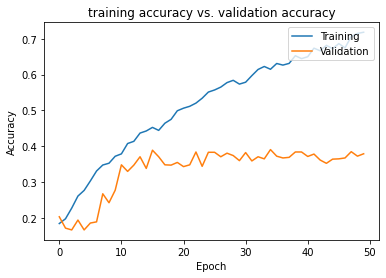

In [114]:
# 1. lamda = 0.0005 / dropout = 0.5 / customized parameters 1
model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
                    Dropout(0.5),
                    BatchNormalization(), # <- Batch normalization layer 1
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
                    Dropout(0.5),
                    #BatchNormalization(), # <- Batch normalization layer 2
                    #Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                    #      bias_initializer=tf.keras.initializers.Constant(value=0.4))
])

# Add a customised batch normalization layer 2
model.add(tf.keras.layers.BatchNormalization(
    momentum=0.95, # default is 0.99
    epsilon=0.0005, #default is 0.001
    axis = -1, #default is -1
    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), # default is beta_initializer='zeros'
    gamma_initializer=tf.keras.initializers.Constant(value=0.9) # default is gamma_initializer='ones'
))

# Add the output layer
model.add(Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4)))


model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Epoch 1/50
36/36 - 7s - loss: 2.0079 - sparse_categorical_accuracy: 0.1747 - val_loss: 1.8269 - val_sparse_categorical_accuracy: 0.1675 - 7s/epoch - 184ms/step
Epoch 2/50
36/36 - 5s - loss: 1.8077 - sparse_categorical_accuracy: 0.1900 - val_loss: 1.8147 - val_sparse_categorical_accuracy: 0.1608 - 5s/epoch - 153ms/step
Epoch 3/50
36/36 - 6s - loss: 1.7902 - sparse_categorical_accuracy: 0.2169 - val_loss: 1.8166 - val_sparse_categorical_accuracy: 0.1858 - 6s/epoch - 158ms/step
Epoch 4/50
36/36 - 5s - loss: 1.7486 - sparse_categorical_accuracy: 0.2353 - val_loss: 1.8878 - val_sparse_categorical_accuracy: 0.1675 - 5s/epoch - 152ms/step
Epoch 5/50
36/36 - 5s - loss: 1.7297 - sparse_categorical_accuracy: 0.2775 - val_loss: 1.9144 - val_sparse_categorical_accuracy: 0.1675 - 5s/epoch - 141ms/step
Epoch 6/50
36/36 - 5s - loss: 1.7106 - sparse_categorical_accuracy: 0.2933 - val_loss: 1.8948 - val_sparse_categorical_accuracy: 0.1750 - 5s/epoch - 140ms/step
Epoch 7/50
36/36 - 5s - loss: 1.6921 - s

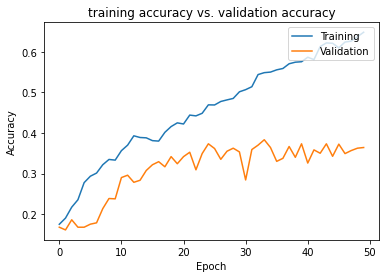

In [115]:
# 2. lamda = 0.001 / dropout = 0.5 / customized parameters 1
model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    Dropout(0.5),
                    BatchNormalization(), # <- Batch normalization layer 1
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    Dropout(0.5),
                    #BatchNormalization(), # <- Batch normalization layer 2
                    #Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                    #      bias_initializer=tf.keras.initializers.Constant(value=0.4))
])

# Add a customised batch normalization layer 2
model.add(tf.keras.layers.BatchNormalization(
    momentum=0.95, # default is 0.99
    epsilon=0.0005, #default is 0.001
    axis = -1, #default is -1
    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), # default is beta_initializer='zeros'
    gamma_initializer=tf.keras.initializers.Constant(value=0.5) # default is gamma_initializer='ones'
))

# Add the output layer
model.add(Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4)))

model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Epoch 1/50
36/36 - 6s - loss: 2.3723 - sparse_categorical_accuracy: 0.1889 - val_loss: 1.8693 - val_sparse_categorical_accuracy: 0.2058 - 6s/epoch - 174ms/step
Epoch 2/50
36/36 - 6s - loss: 1.8052 - sparse_categorical_accuracy: 0.2336 - val_loss: 2.0344 - val_sparse_categorical_accuracy: 0.1950 - 6s/epoch - 153ms/step
Epoch 3/50
36/36 - 5s - loss: 1.7684 - sparse_categorical_accuracy: 0.2828 - val_loss: 2.0113 - val_sparse_categorical_accuracy: 0.1825 - 5s/epoch - 143ms/step
Epoch 4/50
36/36 - 5s - loss: 1.7191 - sparse_categorical_accuracy: 0.3189 - val_loss: 1.8959 - val_sparse_categorical_accuracy: 0.2350 - 5s/epoch - 141ms/step
Epoch 5/50
36/36 - 5s - loss: 1.6993 - sparse_categorical_accuracy: 0.3453 - val_loss: 2.0408 - val_sparse_categorical_accuracy: 0.2092 - 5s/epoch - 138ms/step
Epoch 6/50
36/36 - 5s - loss: 1.6825 - sparse_categorical_accuracy: 0.3681 - val_loss: 1.8759 - val_sparse_categorical_accuracy: 0.3017 - 5s/epoch - 137ms/step
Epoch 7/50
36/36 - 5s - loss: 1.6616 - s

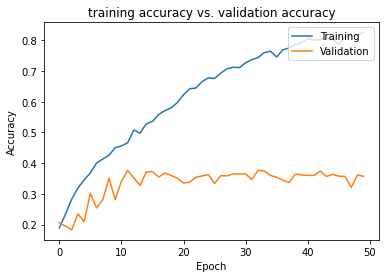

In [116]:
# 3. lamda = 0.003 / dropout = 0.3 / customized parameters 1
model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4),kernel_regularizer=tf.keras.regularizers.l2(0.003)),
                    Dropout(0.3),
                    BatchNormalization(), # <- Batch normalization layer 1
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4),kernel_regularizer=tf.keras.regularizers.l2(0.003)),
                    Dropout(0.3),
                    #BatchNormalization(), # <- Batch normalization layer 2
                    #Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                    #      bias_initializer=tf.keras.initializers.Constant(value=0.4))
])

# Add a customised batch normalization layer 2
model.add(tf.keras.layers.BatchNormalization(
    momentum=0.95, # default is 0.99
    epsilon=0.0005, #default is 0.001
    axis = -1, #default is -1
    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), # default is beta_initializer='zeros'
    gamma_initializer=tf.keras.initializers.Constant(value=0.9) # default is gamma_initializer='ones'
))

# Add the output layer
model.add(Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4)))

model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Epoch 1/50
36/36 - 6s - loss: 2.3140 - sparse_categorical_accuracy: 0.1642 - val_loss: 1.8512 - val_sparse_categorical_accuracy: 0.1667 - 6s/epoch - 178ms/step
Epoch 2/50
36/36 - 5s - loss: 1.8326 - sparse_categorical_accuracy: 0.1731 - val_loss: 1.8166 - val_sparse_categorical_accuracy: 0.1667 - 5s/epoch - 153ms/step
Epoch 3/50
36/36 - 6s - loss: 1.8203 - sparse_categorical_accuracy: 0.1661 - val_loss: 1.8120 - val_sparse_categorical_accuracy: 0.1667 - 6s/epoch - 153ms/step
Epoch 4/50
36/36 - 6s - loss: 1.8134 - sparse_categorical_accuracy: 0.1725 - val_loss: 1.8059 - val_sparse_categorical_accuracy: 0.1675 - 6s/epoch - 155ms/step
Epoch 5/50
36/36 - 5s - loss: 1.8107 - sparse_categorical_accuracy: 0.1658 - val_loss: 1.8054 - val_sparse_categorical_accuracy: 0.1675 - 5s/epoch - 152ms/step
Epoch 6/50
36/36 - 5s - loss: 1.8064 - sparse_categorical_accuracy: 0.1703 - val_loss: 1.8036 - val_sparse_categorical_accuracy: 0.1667 - 5s/epoch - 152ms/step
Epoch 7/50
36/36 - 6s - loss: 1.8038 - s

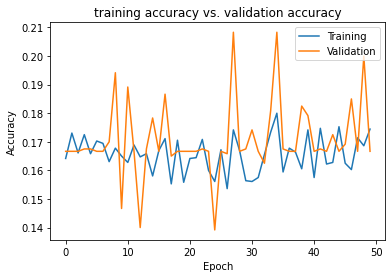

In [117]:
# 4. lamda = 0.003 / dropout = 0.3 / customized parameters 1
model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4),kernel_regularizer=tf.keras.regularizers.l2(0.003)),
                    Dropout(0.9),
                    BatchNormalization(), # <- Batch normalization layer 1
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4),kernel_regularizer=tf.keras.regularizers.l2(0.003)),
                    Dropout(0.9),
                    #BatchNormalization(), # <- Batch normalization layer 2
                    #Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                    #      bias_initializer=tf.keras.initializers.Constant(value=0.4))
])

# Add a customised batch normalization layer 2
model.add(tf.keras.layers.BatchNormalization(
    momentum=0.95, # default is 0.99
    epsilon=0.0001, #default is 0.001
    axis = -1, #default is -1
    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), # default is beta_initializer='zeros'
    gamma_initializer=tf.keras.initializers.Constant(value=0.9) # default is gamma_initializer='ones'
))

# Add the output layer
model.add(Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4)))

model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Epoch 1/50
36/36 - 11s - loss: 2.5326 - sparse_categorical_accuracy: 0.1800 - val_loss: 1.8528 - val_sparse_categorical_accuracy: 0.1667 - 11s/epoch - 306ms/step
Epoch 2/50
36/36 - 8s - loss: 1.8069 - sparse_categorical_accuracy: 0.2156 - val_loss: 1.8538 - val_sparse_categorical_accuracy: 0.1667 - 8s/epoch - 225ms/step
Epoch 3/50
36/36 - 6s - loss: 1.7794 - sparse_categorical_accuracy: 0.2633 - val_loss: 1.9798 - val_sparse_categorical_accuracy: 0.1708 - 6s/epoch - 174ms/step
Epoch 4/50
36/36 - 5s - loss: 1.7754 - sparse_categorical_accuracy: 0.2781 - val_loss: 1.9684 - val_sparse_categorical_accuracy: 0.1817 - 5s/epoch - 139ms/step
Epoch 5/50
36/36 - 5s - loss: 1.7604 - sparse_categorical_accuracy: 0.3039 - val_loss: 1.9222 - val_sparse_categorical_accuracy: 0.2167 - 5s/epoch - 136ms/step
Epoch 6/50
36/36 - 5s - loss: 1.7545 - sparse_categorical_accuracy: 0.3147 - val_loss: 1.8166 - val_sparse_categorical_accuracy: 0.2958 - 5s/epoch - 137ms/step
Epoch 7/50
36/36 - 5s - loss: 1.7666 -

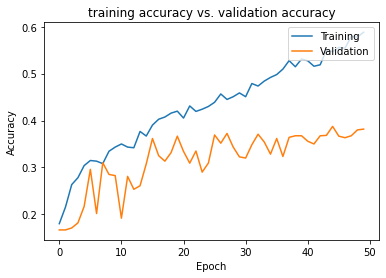

In [126]:
# 5. lamda = 0.005 / dropout = 0.4 / customized parameters 1
model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4),kernel_regularizer=tf.keras.regularizers.l2(0.005)),
                    Dropout(0.4),
                    BatchNormalization(), # <- Batch normalization layer 1
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4),kernel_regularizer=tf.keras.regularizers.l2(0.005)),
                    Dropout(0.4),
                    #BatchNormalization(), # <- Batch normalization layer 2
                    #Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                    #      bias_initializer=tf.keras.initializers.Constant(value=0.4))
])

# Add a customised batch normalization layer 2
model.add(tf.keras.layers.BatchNormalization(
    momentum=0.95, # default is 0.99
    epsilon=0.0005, #default is 0.001
    axis = -1, #default is -1
    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), # default is beta_initializer='zeros'
    gamma_initializer=tf.keras.initializers.Constant(value=0.5) # default is gamma_initializer='ones'
))

# Add the output layer
model.add(Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4)))

model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [127]:
# Model test result with Optimizer = Adamax and epochs = 50
test_loss, test_accuracy = model.evaluate(test_x[..., np.newaxis], test_y.reshape((1200,)))
print('test_loss:',test_loss)
print('test_accuracy:',test_accuracy)

38/38 [==============================] - 1s 14ms/step - loss: 1.9969 - sparse_categorical_accuracy: 0.3983
test_loss: 1.9968739748001099
test_accuracy: 0.398333340883255


Epoch 1/50
36/36 - 11s - loss: 1.9429 - sparse_categorical_accuracy: 0.1881 - val_loss: 1.8349 - val_sparse_categorical_accuracy: 0.2025 - 11s/epoch - 304ms/step
Epoch 2/50
36/36 - 5s - loss: 1.7790 - sparse_categorical_accuracy: 0.2522 - val_loss: 1.8682 - val_sparse_categorical_accuracy: 0.2092 - 5s/epoch - 150ms/step
Epoch 3/50
36/36 - 5s - loss: 1.7092 - sparse_categorical_accuracy: 0.2939 - val_loss: 1.8780 - val_sparse_categorical_accuracy: 0.1783 - 5s/epoch - 137ms/step
Epoch 4/50
36/36 - 5s - loss: 1.6576 - sparse_categorical_accuracy: 0.3383 - val_loss: 1.8113 - val_sparse_categorical_accuracy: 0.2400 - 5s/epoch - 135ms/step
Epoch 5/50
36/36 - 5s - loss: 1.6120 - sparse_categorical_accuracy: 0.3661 - val_loss: 1.8216 - val_sparse_categorical_accuracy: 0.2675 - 5s/epoch - 134ms/step
Epoch 6/50
36/36 - 5s - loss: 1.5606 - sparse_categorical_accuracy: 0.4025 - val_loss: 1.8001 - val_sparse_categorical_accuracy: 0.2742 - 5s/epoch - 136ms/step
Epoch 7/50
36/36 - 5s - loss: 1.5279 -

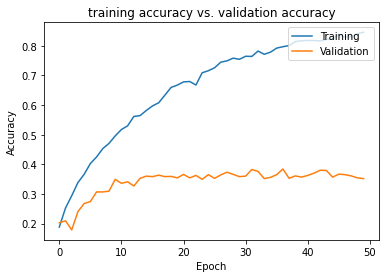

In [121]:
# 6. lamda = 0.0005 / dropout = 0.4 / customized parameters 1
model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4),kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
                    Dropout(0.4),
                    BatchNormalization(), # <- Batch normalization layer 1
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4),kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
                    Dropout(0.4),
                    #BatchNormalization(), # <- Batch normalization layer 2
                    #Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                    #      bias_initializer=tf.keras.initializers.Constant(value=0.4))
])

# Add a customised batch normalization layer 2
model.add(tf.keras.layers.BatchNormalization(
    momentum=0.95, # default is 0.99
    epsilon=0.0005, #default is 0.001
    axis = -1, #default is -1
    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), # default is beta_initializer='zeros'
    gamma_initializer=tf.keras.initializers.Constant(value=0.5) # default is gamma_initializer='ones'
))

# Add the output layer
model.add(Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4)))

model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)
history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 50, batch_size = 100, verbose = 2,validation_split=0.25) 
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

h. Can you improve your validation performance using an early stopping?

Epoch 1/100
36/36 - 7s - loss: 2.5701 - sparse_categorical_accuracy: 0.1775 - val_loss: 1.8542 - val_sparse_categorical_accuracy: 0.1658 - 7s/epoch - 186ms/step
Epoch 2/100
36/36 - 6s - loss: 1.8225 - sparse_categorical_accuracy: 0.2058 - val_loss: 1.8224 - val_sparse_categorical_accuracy: 0.1867 - 6s/epoch - 163ms/step
Epoch 3/100
36/36 - 6s - loss: 1.7866 - sparse_categorical_accuracy: 0.2364 - val_loss: 1.9509 - val_sparse_categorical_accuracy: 0.1717 - 6s/epoch - 155ms/step
Epoch 4/100
36/36 - 5s - loss: 1.7780 - sparse_categorical_accuracy: 0.2736 - val_loss: 2.0030 - val_sparse_categorical_accuracy: 0.1700 - 5s/epoch - 147ms/step
Epoch 5/100
36/36 - 5s - loss: 1.7810 - sparse_categorical_accuracy: 0.2803 - val_loss: 2.1094 - val_sparse_categorical_accuracy: 0.1667 - 5s/epoch - 147ms/step
Epoch 6/100
36/36 - 5s - loss: 1.7840 - sparse_categorical_accuracy: 0.3017 - val_loss: 2.0785 - val_sparse_categorical_accuracy: 0.1675 - 5s/epoch - 147ms/step
Epoch 7/100
36/36 - 5s - loss: 1.7

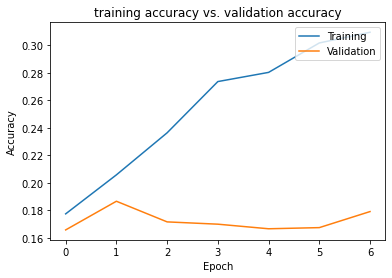

In [120]:
# lamda = 0.005 / dropout = 0.4 / customized parameters 1
model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(42,42,1)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4),kernel_regularizer=tf.keras.regularizers.l2(0.005)),
                    Dropout(0.4),
                    BatchNormalization(), # <- Batch normalization layer 1
                    Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                          bias_initializer=tf.keras.initializers.Constant(value=0.4),kernel_regularizer=tf.keras.regularizers.l2(0.005)),
                    Dropout(0.4),
                    #BatchNormalization(), # <- Batch normalization layer 2
                    #Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                    #      bias_initializer=tf.keras.initializers.Constant(value=0.4))
])

# Add a customised batch normalization layer 2
model.add(tf.keras.layers.BatchNormalization(
    momentum=0.95, # default is 0.99
    epsilon=0.0005, #default is 0.001
    axis = -1, #default is -1
    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), # default is beta_initializer='zeros'
    gamma_initializer=tf.keras.initializers.Constant(value=0.5) # default is gamma_initializer='ones'
))

# Add the output layer
model.add(Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4)))

model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    loss = 'sparse_categorical_crossentropy', 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5) 

history = model.fit(temp_train_x[..., np.newaxis], temp_train_y.reshape((4800,)), epochs = 100, batch_size = 100, verbose = 2,validation_split=0.25,callbacks=[early_stopping]) 
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()